<a href="https://colab.research.google.com/github/kastei/colab/blob/main/%5Bhomework%5Dsemantic_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Базовый поток. Весна 2021</b></h3>

# Сегментация изображений

В этом задании вам предстоит решить задачу сегментации медицинских снимков. Часть кода с загрузкой данных написана за вас. Всю содержательную сторону вопроса вам нужно заполнить самостоятельно. Задание оценивается из 15 баллов. 

Обратите внимание, что отчёт по заданию стоит целых 6 баллов. Он вынесен в отдельный пункт в конце тетради. Это сделано для того, чтобы тетрадь была оформлена как законченный документ о проведении экспериментов. Неотъемлемой составляющей отчёта является ответ на следующие вопросы:

* Что было сделано? Что получилось реализовать, что не получилось?
* Какие результаты ожидалось получить?
* Какие результаты были достигнуты?
* Чем результаты различных подходов отличались друг от друга и от бейзлайна (если таковой присутствует)?




---


1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>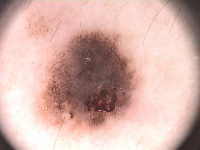</td><td>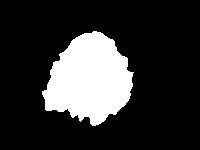</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем **сегментировать** их.

In [1]:
! wget https://www.dropbox.com/s/k88qukc20ljnbuo/PH2Dataset.rar

#альтернативная ссылка на данные: https://www.dropbox.com/s/8lqrloi0mxj2acu/PH2Dataset.rar

--2021-05-31 11:32:57--  https://www.dropbox.com/s/k88qukc20ljnbuo/PH2Dataset.rar
Resolving www.dropbox.com (www.dropbox.com)... 162.125.82.18, 2620:100:6030:18::a27d:5012
Connecting to www.dropbox.com (www.dropbox.com)|162.125.82.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/k88qukc20ljnbuo/PH2Dataset.rar [following]
--2021-05-31 11:32:57--  https://www.dropbox.com/s/raw/k88qukc20ljnbuo/PH2Dataset.rar
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc90e61cf1579861ec1d9ba851a7.dl.dropboxusercontent.com/cd/0/inline/BPhvmAY_4P-uhRtd9YgHcpACnnmZPtF66L_fzBBbXSgMZIcz8O-8LmdORxYNooDSdkGLbU6_JEWqyxY-9zQaD1y_qwVTrk0Qa-5PmrnF9V9LGHKrmrA9reilar5VGEck1960Mn5R1cYyRH0bY0rKPKF7/file# [following]
--2021-05-31 11:32:58--  https://uc90e61cf1579861ec1d9ba851a7.dl.dropboxusercontent.com/cd/0/inline/BPhvmAY_4P-uhRtd9YgHcpACnnmZPtF66L_fzBBbXSgMZIcz8O-8LmdORxYNooDSdkGLbU6_JEWqyxY-9

In [1]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [2]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [3]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [4]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [5]:
len(lesions)

200

In [6]:
import seaborn as sns
sns.set(style="whitegrid", font_scale=1.4)

Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

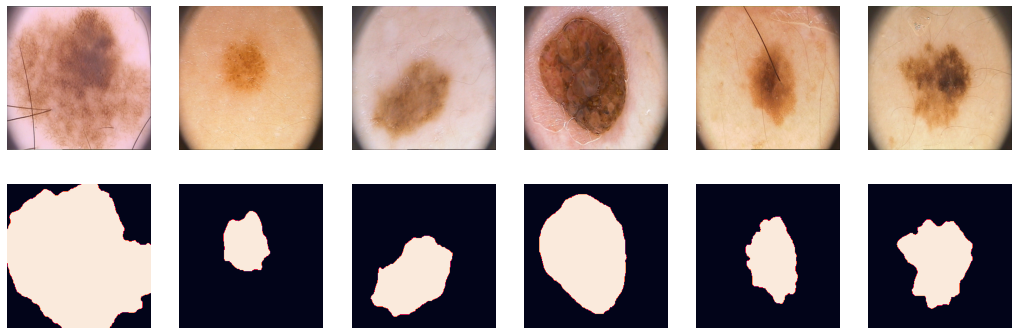

In [7]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show()

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [8]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [9]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [10]:
from torch.utils.data import DataLoader
batch_size = 25
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time
from tqdm import tqdm

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Реализация различных архитектур:
Ваше задание будет состоять в том, чтобы написать несколько нейросетевых архитектур для решения задачи семантической сегментации. Сравнить их по качеству на тесте и испробовать различные лосс функции для них.

-----------------------------------------------------------------------------------------

# SegNet [2 балла]

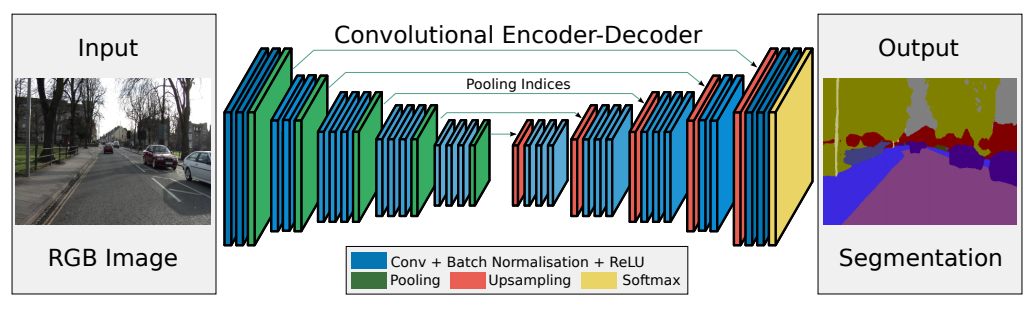

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

Внимательно посмотрите из чего состоит модель и для чего выбраны те или иные блоки.

In [13]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)      
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU() 
        )
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, return_indices=True)
        
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU() 
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, return_indices=True)

        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, return_indices=True)

        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU() 
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, return_indices=True)
        
        self.enc_conv4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU() 
        )
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, return_indices=True)
        
        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=1, padding=0),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=1, padding=0),
            nn.BatchNorm2d(256),
            nn.ReLU() 
        )

        # decoder (upsampling)
        self.upsample0 = nn.MaxUnpool2d(kernel_size=2, stride=2, padding=0) 
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        self.upsample1 = nn.MaxUnpool2d(kernel_size=2, stride=2, padding=0) 
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.upsample2 = nn.MaxUnpool2d(kernel_size=2, stride=2, padding=0) 
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        self.upsample3 = nn.MaxUnpool2d(kernel_size=2, stride=2, padding=0) 
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(32, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU()
        )

        self.upsample4 = nn.MaxUnpool2d(kernel_size=2, stride=2, padding=0) 
        self.dec_conv4 = nn.Sequential(
            nn.Conv2d(16, 1, kernel_size=3, padding=1),
            nn.BatchNorm2d(1),
            nn.ReLU(),
            nn.Conv2d(1, 1, kernel_size=3, padding=1),
            nn.BatchNorm2d(1)
        )

    def forward(self, x):
        # encoder
        e0, i0 = self.pool0(self.enc_conv0(x))
        e1, i1 = self.pool1(self.enc_conv1(e0))        
        e2, i2 = self.pool2(self.enc_conv2(e1))
        e3, i3 = self.pool3(self.enc_conv3(e2))
        e4, i4 = self.pool4(self.enc_conv4(e3))
        
        # bottleneck
        b = self.bottleneck_conv(e4)

        # decoder
        d0 = self.dec_conv0(self.upsample0(b, i4))
        d1 = self.dec_conv1(self.upsample1(d0, i3))        
        d2 = self.dec_conv2(self.upsample2(d1, i2))        
        d3 = self.dec_conv3(self.upsample3(d2, i1))
        d4 = self.dec_conv4(self.upsample4(d3, i0))

        return d4

## Метрика

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Для примера посмотрим на истину (слева) и предсказание (справа):
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


Тогда пересечение и объединение будет выглядеть так:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [14]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    #thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return iou #thresholded

## Функция потерь [1 балл]

Не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь.**

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации. 

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

###BCE loss

In [15]:
def bce_loss(input, target):
    return torch.mean(torch.clamp(input, min=0.) - input*target + torch.log(1 + torch.exp(-abs(input))))

## Тренировка [1 балл]

Мы определим цикл обучения в функции, чтобы мы могли повторно использовать его.

In [16]:
def fit_epoch(model, data_tr, criterion, optimizer):
    model.train()
    avg_loss = 0
    
    for X_batch, Y_batch in data_tr:
        X_batch = X_batch.to(device)
        Y_batch = Y_batch.to(device)
        
        optimizer.zero_grad()
 
        Y_pred = model(X_batch)
        
        loss = criterion(input=Y_pred, target=Y_batch)
        loss.backward()

        optimizer.step()
        
        avg_loss += loss / len(data_tr) 

    return avg_loss

In [17]:
def eval_epoch(model, data_val, criterion):
    model.eval()
    avg_loss = 0
    
    for X_val, Y_val in data_val:
        X_val = X_val.to(device)
        Y_val = Y_val.to(device)
 
        with torch.set_grad_enabled(False):
            Y_pred = model(X_val)
            loss = criterion(input=Y_pred, target=Y_val)
            
        avg_loss += loss / len(data_val)

    return avg_loss 

In [103]:
def train(model, optimizer, criterion, epochs, data_tr, data_val, metric):

    history = []

    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} val_loss {v_loss:0.4f} \
    train_score {t_score:0.4f} val_score {v_score:0.4f}"
    
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50,70], gamma=0.1)
    
    with tqdm(desc="epoch", total=epochs) as pbar_outer:

        for epoch in range(epochs):

            tr_loss = fit_epoch(model, data_tr, criterion, optimizer)
            val_loss = eval_epoch(model, data_val, criterion)
            
            tr_score = score_model(model, metric, data_tr)
            val_score = score_model(model, metric, data_val)

            history.append((tr_loss, val_loss, tr_score, val_score))
            
            pbar_outer.update(1)          
            tqdm.write(log_template.format(ep=epoch+1, t_loss=tr_loss, v_loss=val_loss, \
                                           t_score=tr_score, v_score=val_score))
            
            scheduler.step()
            
    return history

## Инференс [1 балл]

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [106]:
def predict(model, inputs):
    with torch.no_grad():
        model.eval()  # testing mode
        pred = model(inputs.to(device))     
    
    return torch.ones_like(pred) * (pred.sigmoid() > 0.5)

In [20]:
def score_model(model, metric, data):
    scores = 0
    for X_batch, Y_label in data:
        Y_pred = predict(model, X_batch)
        scores += metric(Y_pred, Y_label.to(device)).mean().item()

    return scores/len(data)

## Основной момент: обучение

Обучите вашу модель. Обратите внимание, что обучать необходимо до сходимости. Если указанного количества эпох (20) не хватило, попробуйте изменять количество эпох до сходимости алгоритма. Сходимость определяйте по изменению функции потерь на валидационной выборке.
 С параметрами оптимизатора можно спокойно играть, пока вы не найдете лучший вариант для себя.


In [107]:
model = SegNet().to(device)

max_epochs = 100

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, betas=(0.9, 0.999), weight_decay=0.01)

history_segnet_bce = train(model, optimizer, bce_loss, max_epochs, data_tr, data_val, metric = iou_pytorch)

epoch:   1%|          | 1/100 [00:00<01:25,  1.15it/s]


Epoch 001 train_loss: 0.7495 val_loss 0.7387     train_score 0.3318 val_score 0.3379


epoch:   2%|▏         | 2/100 [00:01<01:25,  1.15it/s]


Epoch 002 train_loss: 0.6905 val_loss 0.7223     train_score 0.3318 val_score 0.3379


epoch:   3%|▎         | 3/100 [00:02<01:24,  1.15it/s]


Epoch 003 train_loss: 0.6457 val_loss 0.7081     train_score 0.3318 val_score 0.3379


epoch:   4%|▍         | 4/100 [00:03<01:22,  1.16it/s]


Epoch 004 train_loss: 0.6153 val_loss 0.6949     train_score 0.3207 val_score 0.3282


epoch:   5%|▌         | 5/100 [00:04<01:21,  1.16it/s]


Epoch 005 train_loss: 0.5643 val_loss 0.6774     train_score 0.0530 val_score 0.0229


epoch:   6%|▌         | 6/100 [00:05<01:21,  1.16it/s]


Epoch 006 train_loss: 0.5164 val_loss 0.6243     train_score 0.2739 val_score 0.2762


epoch:   7%|▋         | 7/100 [00:06<01:20,  1.16it/s]


Epoch 007 train_loss: 0.5075 val_loss 0.5699     train_score 0.3428 val_score 0.3476


epoch:   8%|▊         | 8/100 [00:06<01:19,  1.16it/s]


Epoch 008 train_loss: 0.4666 val_loss 0.6028     train_score 0.1997 val_score 0.2284


epoch:   9%|▉         | 9/100 [00:07<01:18,  1.16it/s]


Epoch 009 train_loss: 0.4509 val_loss 0.5299     train_score 0.3525 val_score 0.3699


epoch:  10%|█         | 10/100 [00:08<01:17,  1.16it/s]


Epoch 010 train_loss: 0.4279 val_loss 0.5264     train_score 0.3725 val_score 0.3785


epoch:  11%|█         | 11/100 [00:09<01:16,  1.16it/s]


Epoch 011 train_loss: 0.4208 val_loss 0.5356     train_score 0.3378 val_score 0.3380


epoch:  12%|█▏        | 12/100 [00:10<01:16,  1.16it/s]


Epoch 012 train_loss: 0.4199 val_loss 0.5531     train_score 0.3097 val_score 0.3052


epoch:  13%|█▎        | 13/100 [00:11<01:15,  1.16it/s]


Epoch 013 train_loss: 0.4101 val_loss 0.6225     train_score 0.0965 val_score 0.0745


epoch:  14%|█▍        | 14/100 [00:12<01:14,  1.16it/s]


Epoch 014 train_loss: 0.4057 val_loss 0.4133     train_score 0.7318 val_score 0.7269


epoch:  15%|█▌        | 15/100 [00:12<01:13,  1.16it/s]


Epoch 015 train_loss: 0.4215 val_loss 0.4408     train_score 0.6455 val_score 0.6715


epoch:  16%|█▌        | 16/100 [00:13<01:12,  1.16it/s]


Epoch 016 train_loss: 0.4134 val_loss 0.5868     train_score 0.1862 val_score 0.1889


epoch:  17%|█▋        | 17/100 [00:14<01:11,  1.16it/s]


Epoch 017 train_loss: 0.3934 val_loss 0.4034     train_score 0.7336 val_score 0.7095


epoch:  18%|█▊        | 18/100 [00:15<01:10,  1.16it/s]


Epoch 018 train_loss: 0.3994 val_loss 0.4042     train_score 0.7904 val_score 0.7377


epoch:  19%|█▉        | 19/100 [00:16<01:09,  1.16it/s]


Epoch 019 train_loss: 0.3808 val_loss 0.4201     train_score 0.7991 val_score 0.7502


epoch:  20%|██        | 20/100 [00:17<01:08,  1.16it/s]


Epoch 020 train_loss: 0.4013 val_loss 0.4194     train_score 0.7274 val_score 0.7018


epoch:  21%|██        | 21/100 [00:18<01:08,  1.16it/s]


Epoch 021 train_loss: 0.3794 val_loss 0.4218     train_score 0.7851 val_score 0.7202


epoch:  22%|██▏       | 22/100 [00:19<01:07,  1.16it/s]


Epoch 022 train_loss: 0.3873 val_loss 0.3907     train_score 0.8102 val_score 0.7684


epoch:  23%|██▎       | 23/100 [00:19<01:06,  1.16it/s]


Epoch 023 train_loss: 0.3816 val_loss 0.3879     train_score 0.7557 val_score 0.7280


epoch:  24%|██▍       | 24/100 [00:20<01:05,  1.16it/s]


Epoch 024 train_loss: 0.3704 val_loss 0.3862     train_score 0.7632 val_score 0.7269


epoch:  25%|██▌       | 25/100 [00:21<01:04,  1.16it/s]


Epoch 025 train_loss: 0.3657 val_loss 0.3940     train_score 0.8260 val_score 0.7744


epoch:  26%|██▌       | 26/100 [00:22<01:04,  1.15it/s]


Epoch 026 train_loss: 0.3644 val_loss 0.4802     train_score 0.5855 val_score 0.5620


epoch:  27%|██▋       | 27/100 [00:23<01:03,  1.15it/s]


Epoch 027 train_loss: 0.3742 val_loss 0.3978     train_score 0.7824 val_score 0.7372


epoch:  28%|██▊       | 28/100 [00:24<01:02,  1.16it/s]


Epoch 028 train_loss: 0.3595 val_loss 0.4026     train_score 0.7966 val_score 0.7352


epoch:  29%|██▉       | 29/100 [00:25<01:01,  1.16it/s]


Epoch 029 train_loss: 0.3663 val_loss 0.5788     train_score 0.4908 val_score 0.5198


epoch:  30%|███       | 30/100 [00:25<01:00,  1.16it/s]


Epoch 030 train_loss: 0.3898 val_loss 0.3745     train_score 0.8024 val_score 0.7549


epoch:  31%|███       | 31/100 [00:26<00:59,  1.16it/s]


Epoch 031 train_loss: 0.3748 val_loss 0.3912     train_score 0.7263 val_score 0.7131


epoch:  32%|███▏      | 32/100 [00:27<00:58,  1.16it/s]


Epoch 032 train_loss: 0.3705 val_loss 0.4103     train_score 0.7275 val_score 0.7105


epoch:  33%|███▎      | 33/100 [00:28<00:57,  1.16it/s]


Epoch 033 train_loss: 0.3642 val_loss 0.3562     train_score 0.8167 val_score 0.7772


epoch:  34%|███▍      | 34/100 [00:29<00:56,  1.16it/s]


Epoch 034 train_loss: 0.3474 val_loss 0.3687     train_score 0.7485 val_score 0.7300


epoch:  35%|███▌      | 35/100 [00:30<00:56,  1.16it/s]


Epoch 035 train_loss: 0.3511 val_loss 0.3638     train_score 0.8223 val_score 0.7680


epoch:  36%|███▌      | 36/100 [00:31<00:55,  1.16it/s]


Epoch 036 train_loss: 0.3525 val_loss 0.3550     train_score 0.8261 val_score 0.7784


epoch:  37%|███▋      | 37/100 [00:31<00:54,  1.16it/s]


Epoch 037 train_loss: 0.3704 val_loss 0.3682     train_score 0.8096 val_score 0.7614


epoch:  38%|███▊      | 38/100 [00:32<00:53,  1.16it/s]


Epoch 038 train_loss: 0.3627 val_loss 0.3848     train_score 0.7277 val_score 0.7018


epoch:  39%|███▉      | 39/100 [00:33<00:52,  1.16it/s]


Epoch 039 train_loss: 0.3491 val_loss 0.3843     train_score 0.7316 val_score 0.7114


epoch:  40%|████      | 40/100 [00:34<00:51,  1.16it/s]


Epoch 040 train_loss: 0.3537 val_loss 0.3774     train_score 0.7697 val_score 0.7493


epoch:  41%|████      | 41/100 [00:35<00:50,  1.16it/s]


Epoch 041 train_loss: 0.3436 val_loss 0.3709     train_score 0.8151 val_score 0.7692


epoch:  42%|████▏     | 42/100 [00:36<00:50,  1.16it/s]


Epoch 042 train_loss: 0.3465 val_loss 0.3745     train_score 0.8076 val_score 0.7551


epoch:  43%|████▎     | 43/100 [00:37<00:49,  1.16it/s]


Epoch 043 train_loss: 0.3345 val_loss 0.3515     train_score 0.8229 val_score 0.7675


epoch:  44%|████▍     | 44/100 [00:38<00:48,  1.16it/s]


Epoch 044 train_loss: 0.3323 val_loss 0.3500     train_score 0.8319 val_score 0.7742


epoch:  45%|████▌     | 45/100 [00:38<00:47,  1.16it/s]


Epoch 045 train_loss: 0.3309 val_loss 0.3542     train_score 0.8511 val_score 0.7933


epoch:  46%|████▌     | 46/100 [00:39<00:46,  1.16it/s]


Epoch 046 train_loss: 0.3315 val_loss 0.3880     train_score 0.7673 val_score 0.7377


epoch:  47%|████▋     | 47/100 [00:40<00:45,  1.16it/s]


Epoch 047 train_loss: 0.3370 val_loss 0.3747     train_score 0.7931 val_score 0.7388


epoch:  48%|████▊     | 48/100 [00:41<00:44,  1.16it/s]


Epoch 048 train_loss: 0.3344 val_loss 0.3704     train_score 0.7909 val_score 0.7455


epoch:  49%|████▉     | 49/100 [00:42<00:43,  1.16it/s]


Epoch 049 train_loss: 0.3347 val_loss 0.3759     train_score 0.7944 val_score 0.7484


epoch:  50%|█████     | 50/100 [00:43<00:43,  1.16it/s]


Epoch 050 train_loss: 0.3285 val_loss 0.3509     train_score 0.8235 val_score 0.7738


epoch:  51%|█████     | 51/100 [00:44<00:42,  1.16it/s]


Epoch 051 train_loss: 0.3211 val_loss 0.3416     train_score 0.8472 val_score 0.7912


epoch:  52%|█████▏    | 52/100 [00:44<00:41,  1.16it/s]


Epoch 052 train_loss: 0.3233 val_loss 0.3442     train_score 0.8388 val_score 0.7881


epoch:  53%|█████▎    | 53/100 [00:45<00:40,  1.16it/s]


Epoch 053 train_loss: 0.3260 val_loss 0.3444     train_score 0.8369 val_score 0.7864


epoch:  54%|█████▍    | 54/100 [00:46<00:39,  1.16it/s]


Epoch 054 train_loss: 0.3259 val_loss 0.3450     train_score 0.8435 val_score 0.7850


epoch:  55%|█████▌    | 55/100 [00:47<00:38,  1.16it/s]


Epoch 055 train_loss: 0.3119 val_loss 0.3424     train_score 0.8558 val_score 0.7881


epoch:  56%|█████▌    | 56/100 [00:48<00:38,  1.16it/s]


Epoch 056 train_loss: 0.3139 val_loss 0.3396     train_score 0.8637 val_score 0.7944


epoch:  57%|█████▋    | 57/100 [00:49<00:37,  1.16it/s]


Epoch 057 train_loss: 0.3263 val_loss 0.3377     train_score 0.8682 val_score 0.7973


epoch:  58%|█████▊    | 58/100 [00:50<00:36,  1.15it/s]


Epoch 058 train_loss: 0.3147 val_loss 0.3396     train_score 0.8713 val_score 0.7986


epoch:  59%|█████▉    | 59/100 [00:50<00:35,  1.15it/s]


Epoch 059 train_loss: 0.3064 val_loss 0.3400     train_score 0.8734 val_score 0.8005


epoch:  60%|██████    | 60/100 [00:51<00:34,  1.15it/s]


Epoch 060 train_loss: 0.3130 val_loss 0.3402     train_score 0.8743 val_score 0.8010


epoch:  61%|██████    | 61/100 [00:52<00:33,  1.15it/s]


Epoch 061 train_loss: 0.3161 val_loss 0.3398     train_score 0.8749 val_score 0.8020


epoch:  62%|██████▏   | 62/100 [00:53<00:32,  1.16it/s]


Epoch 062 train_loss: 0.3291 val_loss 0.3385     train_score 0.8766 val_score 0.8034


epoch:  63%|██████▎   | 63/100 [00:54<00:31,  1.16it/s]


Epoch 063 train_loss: 0.3134 val_loss 0.3379     train_score 0.8789 val_score 0.8045


epoch:  64%|██████▍   | 64/100 [00:55<00:31,  1.16it/s]


Epoch 064 train_loss: 0.3095 val_loss 0.3380     train_score 0.8800 val_score 0.8055


epoch:  65%|██████▌   | 65/100 [00:56<00:30,  1.16it/s]


Epoch 065 train_loss: 0.3096 val_loss 0.3377     train_score 0.8804 val_score 0.8058


epoch:  66%|██████▌   | 66/100 [00:56<00:29,  1.16it/s]


Epoch 066 train_loss: 0.3108 val_loss 0.3371     train_score 0.8804 val_score 0.8073


epoch:  67%|██████▋   | 67/100 [00:57<00:28,  1.16it/s]


Epoch 067 train_loss: 0.3115 val_loss 0.3363     train_score 0.8809 val_score 0.8084


epoch:  68%|██████▊   | 68/100 [00:58<00:27,  1.16it/s]


Epoch 068 train_loss: 0.3048 val_loss 0.3371     train_score 0.8816 val_score 0.8088


epoch:  69%|██████▉   | 69/100 [00:59<00:26,  1.16it/s]


Epoch 069 train_loss: 0.3020 val_loss 0.3371     train_score 0.8827 val_score 0.8085


epoch:  70%|███████   | 70/100 [01:00<00:25,  1.16it/s]


Epoch 070 train_loss: 0.3089 val_loss 0.3365     train_score 0.8835 val_score 0.8102


epoch:  71%|███████   | 71/100 [01:01<00:25,  1.16it/s]


Epoch 071 train_loss: 0.3045 val_loss 0.3355     train_score 0.8830 val_score 0.8109


epoch:  72%|███████▏  | 72/100 [01:02<00:24,  1.16it/s]


Epoch 072 train_loss: 0.3068 val_loss 0.3352     train_score 0.8821 val_score 0.8109


epoch:  73%|███████▎  | 73/100 [01:03<00:23,  1.16it/s]


Epoch 073 train_loss: 0.3186 val_loss 0.3345     train_score 0.8820 val_score 0.8111


epoch:  74%|███████▍  | 74/100 [01:03<00:22,  1.16it/s]


Epoch 074 train_loss: 0.3063 val_loss 0.3346     train_score 0.8813 val_score 0.8107


epoch:  75%|███████▌  | 75/100 [01:04<00:21,  1.16it/s]


Epoch 075 train_loss: 0.3072 val_loss 0.3349     train_score 0.8804 val_score 0.8100


epoch:  76%|███████▌  | 76/100 [01:05<00:20,  1.16it/s]


Epoch 076 train_loss: 0.3087 val_loss 0.3352     train_score 0.8796 val_score 0.8095


epoch:  77%|███████▋  | 77/100 [01:06<00:19,  1.16it/s]


Epoch 077 train_loss: 0.3058 val_loss 0.3348     train_score 0.8806 val_score 0.8097


epoch:  78%|███████▊  | 78/100 [01:07<00:18,  1.16it/s]


Epoch 078 train_loss: 0.3038 val_loss 0.3348     train_score 0.8809 val_score 0.8097


epoch:  79%|███████▉  | 79/100 [01:08<00:18,  1.16it/s]


Epoch 079 train_loss: 0.3110 val_loss 0.3344     train_score 0.8819 val_score 0.8100


epoch:  80%|████████  | 80/100 [01:09<00:17,  1.16it/s]


Epoch 080 train_loss: 0.3103 val_loss 0.3343     train_score 0.8823 val_score 0.8102


epoch:  81%|████████  | 81/100 [01:09<00:16,  1.16it/s]


Epoch 081 train_loss: 0.3035 val_loss 0.3343     train_score 0.8825 val_score 0.8102


epoch:  82%|████████▏ | 82/100 [01:10<00:15,  1.16it/s]


Epoch 082 train_loss: 0.3023 val_loss 0.3341     train_score 0.8827 val_score 0.8105


epoch:  83%|████████▎ | 83/100 [01:11<00:14,  1.16it/s]


Epoch 083 train_loss: 0.3080 val_loss 0.3346     train_score 0.8819 val_score 0.8103


epoch:  84%|████████▍ | 84/100 [01:12<00:13,  1.16it/s]


Epoch 084 train_loss: 0.3039 val_loss 0.3344     train_score 0.8824 val_score 0.8103


epoch:  85%|████████▌ | 85/100 [01:13<00:12,  1.16it/s]


Epoch 085 train_loss: 0.3011 val_loss 0.3343     train_score 0.8828 val_score 0.8106


epoch:  86%|████████▌ | 86/100 [01:14<00:12,  1.16it/s]


Epoch 086 train_loss: 0.3040 val_loss 0.3344     train_score 0.8830 val_score 0.8106


epoch:  87%|████████▋ | 87/100 [01:15<00:11,  1.16it/s]


Epoch 087 train_loss: 0.3101 val_loss 0.3343     train_score 0.8827 val_score 0.8109


epoch:  88%|████████▊ | 88/100 [01:15<00:10,  1.16it/s]


Epoch 088 train_loss: 0.3038 val_loss 0.3344     train_score 0.8826 val_score 0.8108


epoch:  89%|████████▉ | 89/100 [01:16<00:09,  1.16it/s]


Epoch 089 train_loss: 0.3092 val_loss 0.3343     train_score 0.8834 val_score 0.8107


epoch:  90%|█████████ | 90/100 [01:17<00:08,  1.16it/s]


Epoch 090 train_loss: 0.3031 val_loss 0.3342     train_score 0.8836 val_score 0.8108


epoch:  91%|█████████ | 91/100 [01:18<00:07,  1.15it/s]


Epoch 091 train_loss: 0.3049 val_loss 0.3341     train_score 0.8836 val_score 0.8111


epoch:  92%|█████████▏| 92/100 [01:19<00:06,  1.15it/s]


Epoch 092 train_loss: 0.3073 val_loss 0.3339     train_score 0.8843 val_score 0.8111


epoch:  93%|█████████▎| 93/100 [01:20<00:06,  1.16it/s]


Epoch 093 train_loss: 0.3088 val_loss 0.3344     train_score 0.8836 val_score 0.8108


epoch:  94%|█████████▍| 94/100 [01:21<00:05,  1.16it/s]


Epoch 094 train_loss: 0.3244 val_loss 0.3347     train_score 0.8827 val_score 0.8104


epoch:  95%|█████████▌| 95/100 [01:22<00:04,  1.16it/s]


Epoch 095 train_loss: 0.3135 val_loss 0.3342     train_score 0.8833 val_score 0.8108


epoch:  96%|█████████▌| 96/100 [01:22<00:03,  1.16it/s]


Epoch 096 train_loss: 0.3085 val_loss 0.3343     train_score 0.8827 val_score 0.8107


epoch:  97%|█████████▋| 97/100 [01:23<00:02,  1.16it/s]


Epoch 097 train_loss: 0.3029 val_loss 0.3339     train_score 0.8836 val_score 0.8113


epoch:  98%|█████████▊| 98/100 [01:24<00:01,  1.15it/s]


Epoch 098 train_loss: 0.3101 val_loss 0.3340     train_score 0.8836 val_score 0.8116


epoch:  99%|█████████▉| 99/100 [01:25<00:00,  1.16it/s]


Epoch 099 train_loss: 0.3011 val_loss 0.3338     train_score 0.8840 val_score 0.8119


epoch: 100%|██████████| 100/100 [01:26<00:00,  1.16it/s]


Epoch 100 train_loss: 0.3027 val_loss 0.3337     train_score 0.8842 val_score 0.8121


In [108]:
score_segnet_bce = score_model(model, iou_pytorch, data_ts)
score_segnet_bce

0.8332350254058838

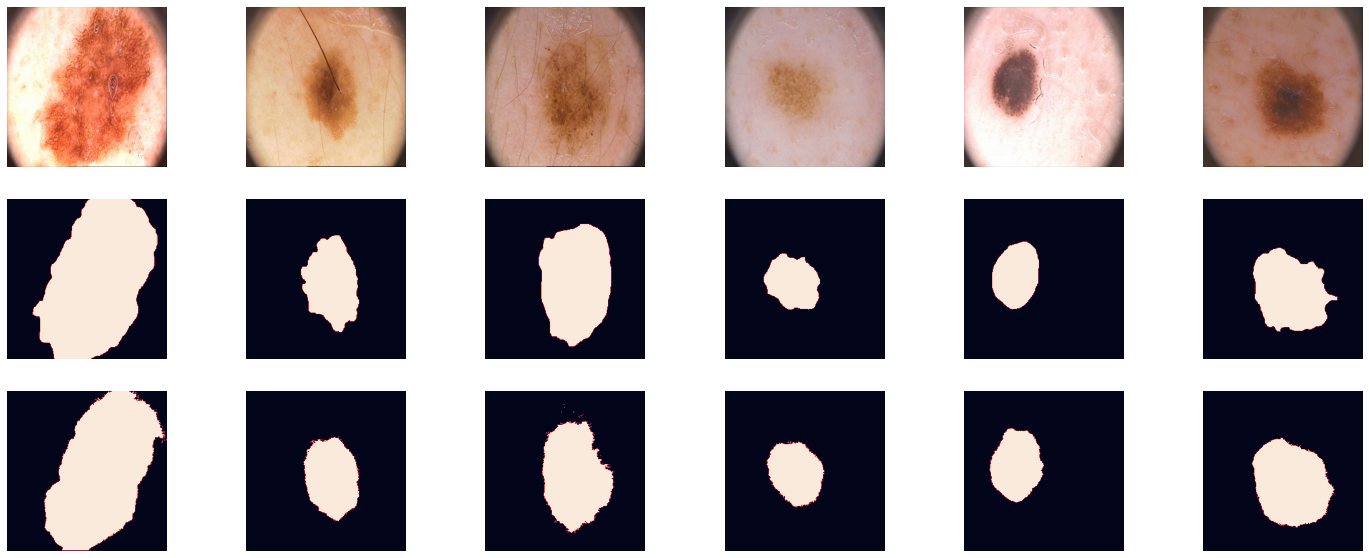

In [109]:
X_val, Y_val = next(iter(data_ts))
Y_pred = predict(model, X_val).cpu()    

fig, ax = plt.subplots(nrows=3, ncols=6, figsize=(25, 10), \
                        sharey=True, sharex=True)

for i in range(6):
    
    ax[0, i].imshow(X_val[i].numpy().transpose((1, 2, 0)))
    ax[0, i].axis('off')
   
    ax[1, i].imshow(np.rollaxis(Y_val[i,0].numpy(), 0))    
    ax[1, i].axis('off')

    ax[2, i].imshow(np.rollaxis(Y_pred[i,0].numpy(), 0))
    ax[2, i].axis('off')

plt.show()

In [110]:
def plot_history(history, title=''):
    train_loss, val_loss, train_score, val_score = zip(*history)
    
    plt.figure(figsize=(15, 6))
    plt.title(title)
    plt.plot(train_loss, label="train_loss")
    plt.plot(val_loss, label="val_loss")
    plt.legend(loc='best')
    plt.ylabel("loss")

    plt.figure(figsize=(15, 6))
    plt.plot(train_score, label="train_score")
    plt.plot(val_score, label="val_score")
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("score")
    
    plt.show()

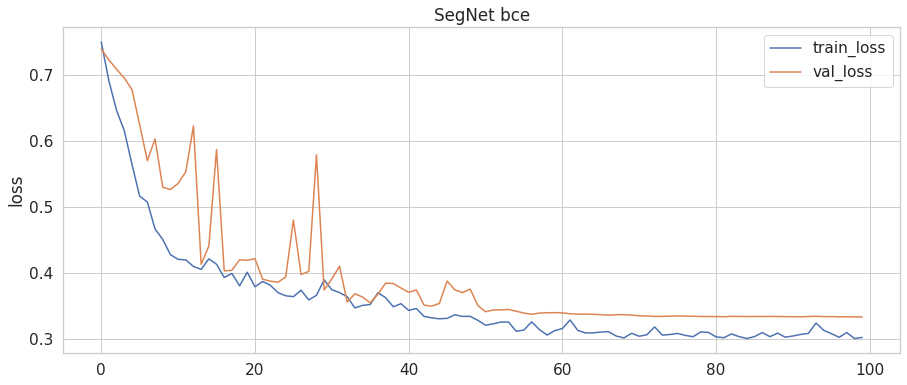

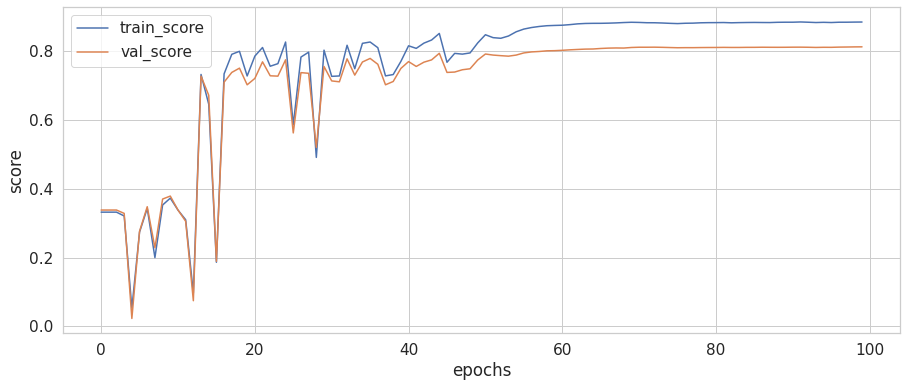

In [111]:
plot_history(history_segnet_bce, title='SegNet bce')

Ответьте себе на вопрос: не переобучается ли моя модель?

Судя по графику после 80 эпохи, loss и score почти не меняется и на тестовой и на валидационной выборке. Хотя при этом большой разницы между предсказанием на тестовой и валидационной выборке нет. Скорее модель недообучается из-за недостаточных данных, а всю тестовую выборку запомнить не может.

-----------------------------------------------------------------------------------------

## Дополнительные функции потерь [2 балла] 

###DICE

 В данном разделе вам потребуется имплементировать две функции потерь:
 DICE и Focal loss. 
 Если у вас что-то не учится, велика вероятность, что вы ошиблись или учите слишком мало эпох, прежде чем бить тревогу попробуйте перебрать различные варианты и убедитесь, что во всех других сетапах сеть достигает желанного результата. СПОЙЛЕР: учиться она будет при всех лоссах, предложенных в этом задании.


**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \sum_i\frac{2X_iY_i}{X_i+Y_i}.$$

Не забудьте подумать о численной нестабильности, возникающей в математической формуле.


In [55]:
def dice_loss(input, target):
    smooth = 1e-6
    inputs = input.sigmoid()
    labels = target

    intersection = (inputs * labels).sum()
    dice = (2.*intersection + smooth)/(inputs.sum() + labels.sum() + smooth)

    return 1 - dice #/(256*256)

Обучим и проведём тестирование:

In [112]:
model = SegNet().to(device)

max_epochs = 100

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, betas=(0.9, 0.999), weight_decay=0.01)

history_segnet_dice = train(model, optimizer, dice_loss, max_epochs, data_tr, data_val, metric = iou_pytorch)

epoch:   1%|          | 1/100 [00:00<01:26,  1.15it/s]


Epoch 001 train_loss: 0.5994 val_loss 0.6036     train_score 0.0000 val_score 0.0000


epoch:   2%|▏         | 2/100 [00:01<01:24,  1.15it/s]


Epoch 002 train_loss: 0.5734 val_loss 0.6013     train_score 0.0088 val_score 0.0084


epoch:   3%|▎         | 3/100 [00:02<01:23,  1.16it/s]


Epoch 003 train_loss: 0.5392 val_loss 0.6002     train_score 0.1432 val_score 0.1489


epoch:   4%|▍         | 4/100 [00:03<01:22,  1.16it/s]


Epoch 004 train_loss: 0.5055 val_loss 0.6050     train_score 0.1425 val_score 0.1478


epoch:   5%|▌         | 5/100 [00:04<01:21,  1.16it/s]


Epoch 005 train_loss: 0.4781 val_loss 0.6088     train_score 0.1292 val_score 0.1337


epoch:   6%|▌         | 6/100 [00:05<01:20,  1.16it/s]


Epoch 006 train_loss: 0.4503 val_loss 0.6164     train_score 0.0757 val_score 0.0762


epoch:   7%|▋         | 7/100 [00:06<01:20,  1.16it/s]


Epoch 007 train_loss: 0.4211 val_loss 0.6098     train_score 0.1228 val_score 0.1194


epoch:   8%|▊         | 8/100 [00:06<01:19,  1.16it/s]


Epoch 008 train_loss: 0.4092 val_loss 0.5901     train_score 0.2558 val_score 0.2541


epoch:   9%|▉         | 9/100 [00:07<01:18,  1.16it/s]


Epoch 009 train_loss: 0.4016 val_loss 0.5744     train_score 0.3337 val_score 0.3118


epoch:  10%|█         | 10/100 [00:08<01:17,  1.16it/s]


Epoch 010 train_loss: 0.4037 val_loss 0.5435     train_score 0.4455 val_score 0.4233


epoch:  11%|█         | 11/100 [00:09<01:16,  1.16it/s]


Epoch 011 train_loss: 0.3934 val_loss 0.4810     train_score 0.6247 val_score 0.5868


epoch:  12%|█▏        | 12/100 [00:10<01:15,  1.16it/s]


Epoch 012 train_loss: 0.3876 val_loss 0.4477     train_score 0.6241 val_score 0.5970


epoch:  13%|█▎        | 13/100 [00:11<01:15,  1.16it/s]


Epoch 013 train_loss: 0.3851 val_loss 0.4203     train_score 0.6745 val_score 0.6571


epoch:  14%|█▍        | 14/100 [00:12<01:14,  1.16it/s]


Epoch 014 train_loss: 0.3904 val_loss 0.4075     train_score 0.7343 val_score 0.6979


epoch:  15%|█▌        | 15/100 [00:12<01:13,  1.16it/s]


Epoch 015 train_loss: 0.3787 val_loss 0.3995     train_score 0.7095 val_score 0.6872


epoch:  16%|█▌        | 16/100 [00:13<01:12,  1.16it/s]


Epoch 016 train_loss: 0.3835 val_loss 0.4031     train_score 0.6512 val_score 0.6343


epoch:  17%|█▋        | 17/100 [00:14<01:11,  1.17it/s]


Epoch 017 train_loss: 0.3784 val_loss 0.4014     train_score 0.6551 val_score 0.6549


epoch:  18%|█▊        | 18/100 [00:15<01:10,  1.17it/s]


Epoch 018 train_loss: 0.3795 val_loss 0.3875     train_score 0.7431 val_score 0.7063


epoch:  19%|█▉        | 19/100 [00:16<01:09,  1.16it/s]


Epoch 019 train_loss: 0.3881 val_loss 0.3825     train_score 0.7583 val_score 0.7228


epoch:  20%|██        | 20/100 [00:17<01:08,  1.16it/s]


Epoch 020 train_loss: 0.3687 val_loss 0.3692     train_score 0.7840 val_score 0.7431


epoch:  21%|██        | 21/100 [00:18<01:07,  1.16it/s]


Epoch 021 train_loss: 0.3764 val_loss 0.3697     train_score 0.7675 val_score 0.7274


epoch:  22%|██▏       | 22/100 [00:18<01:06,  1.17it/s]


Epoch 022 train_loss: 0.3713 val_loss 0.3780     train_score 0.7294 val_score 0.6919


epoch:  23%|██▎       | 23/100 [00:19<01:06,  1.17it/s]


Epoch 023 train_loss: 0.3686 val_loss 0.3955     train_score 0.6677 val_score 0.6667


epoch:  24%|██▍       | 24/100 [00:20<01:05,  1.16it/s]


Epoch 024 train_loss: 0.3662 val_loss 0.3763     train_score 0.7519 val_score 0.7222


epoch:  25%|██▌       | 25/100 [00:21<01:04,  1.16it/s]


Epoch 025 train_loss: 0.3690 val_loss 0.3769     train_score 0.7609 val_score 0.7296


epoch:  26%|██▌       | 26/100 [00:22<01:03,  1.16it/s]


Epoch 026 train_loss: 0.3728 val_loss 0.3701     train_score 0.7804 val_score 0.7476


epoch:  27%|██▋       | 27/100 [00:23<01:02,  1.16it/s]


Epoch 027 train_loss: 0.3636 val_loss 0.3790     train_score 0.7751 val_score 0.7448


epoch:  28%|██▊       | 28/100 [00:24<01:01,  1.16it/s]


Epoch 028 train_loss: 0.3634 val_loss 0.3774     train_score 0.7807 val_score 0.7421


epoch:  29%|██▉       | 29/100 [00:24<01:01,  1.16it/s]


Epoch 029 train_loss: 0.3563 val_loss 0.3755     train_score 0.7910 val_score 0.7369


epoch:  30%|███       | 30/100 [00:25<01:00,  1.16it/s]


Epoch 030 train_loss: 0.3543 val_loss 0.3739     train_score 0.8067 val_score 0.7450


epoch:  31%|███       | 31/100 [00:26<00:59,  1.16it/s]


Epoch 031 train_loss: 0.3593 val_loss 0.3683     train_score 0.8089 val_score 0.7484


epoch:  32%|███▏      | 32/100 [00:27<00:58,  1.17it/s]


Epoch 032 train_loss: 0.3541 val_loss 0.3652     train_score 0.7610 val_score 0.7327


epoch:  33%|███▎      | 33/100 [00:28<00:57,  1.17it/s]


Epoch 033 train_loss: 0.3510 val_loss 0.3646     train_score 0.8101 val_score 0.7556


epoch:  34%|███▍      | 34/100 [00:29<00:56,  1.17it/s]


Epoch 034 train_loss: 0.3488 val_loss 0.3576     train_score 0.8143 val_score 0.7626


epoch:  35%|███▌      | 35/100 [00:30<00:55,  1.17it/s]


Epoch 035 train_loss: 0.3539 val_loss 0.3685     train_score 0.7612 val_score 0.7156


epoch:  36%|███▌      | 36/100 [00:30<00:55,  1.16it/s]


Epoch 036 train_loss: 0.3469 val_loss 0.3720     train_score 0.7316 val_score 0.7035


epoch:  37%|███▋      | 37/100 [00:31<00:54,  1.16it/s]


Epoch 037 train_loss: 0.3430 val_loss 0.3611     train_score 0.7852 val_score 0.7546


epoch:  38%|███▊      | 38/100 [00:32<00:53,  1.16it/s]


Epoch 038 train_loss: 0.3544 val_loss 0.3572     train_score 0.8051 val_score 0.7640


epoch:  39%|███▉      | 39/100 [00:33<00:52,  1.16it/s]


Epoch 039 train_loss: 0.3412 val_loss 0.3525     train_score 0.8167 val_score 0.7667


epoch:  40%|████      | 40/100 [00:34<00:51,  1.16it/s]


Epoch 040 train_loss: 0.3451 val_loss 0.3541     train_score 0.8432 val_score 0.7817


epoch:  41%|████      | 41/100 [00:35<00:50,  1.16it/s]


Epoch 041 train_loss: 0.3446 val_loss 0.3538     train_score 0.8395 val_score 0.7892


epoch:  42%|████▏     | 42/100 [00:36<00:49,  1.16it/s]


Epoch 042 train_loss: 0.3432 val_loss 0.3543     train_score 0.8269 val_score 0.7704


epoch:  43%|████▎     | 43/100 [00:36<00:49,  1.16it/s]


Epoch 043 train_loss: 0.3412 val_loss 0.3488     train_score 0.8126 val_score 0.7723


epoch:  44%|████▍     | 44/100 [00:37<00:48,  1.16it/s]


Epoch 044 train_loss: 0.3404 val_loss 0.3504     train_score 0.8319 val_score 0.7723


epoch:  45%|████▌     | 45/100 [00:38<00:47,  1.16it/s]


Epoch 045 train_loss: 0.3325 val_loss 0.3853     train_score 0.6898 val_score 0.6677


epoch:  46%|████▌     | 46/100 [00:39<00:46,  1.16it/s]


Epoch 046 train_loss: 0.3479 val_loss 0.3547     train_score 0.7835 val_score 0.7506


epoch:  47%|████▋     | 47/100 [00:40<00:45,  1.16it/s]


Epoch 047 train_loss: 0.3418 val_loss 0.3518     train_score 0.8250 val_score 0.7711


epoch:  48%|████▊     | 48/100 [00:41<00:44,  1.16it/s]


Epoch 048 train_loss: 0.3471 val_loss 0.3515     train_score 0.8276 val_score 0.7779


epoch:  49%|████▉     | 49/100 [00:42<00:43,  1.16it/s]


Epoch 049 train_loss: 0.3387 val_loss 0.3464     train_score 0.7977 val_score 0.7550


epoch:  50%|█████     | 50/100 [00:43<00:43,  1.16it/s]


Epoch 050 train_loss: 0.3287 val_loss 0.3503     train_score 0.7556 val_score 0.7199


epoch:  51%|█████     | 51/100 [00:43<00:42,  1.16it/s]


Epoch 051 train_loss: 0.3305 val_loss 0.3412     train_score 0.8075 val_score 0.7719


epoch:  52%|█████▏    | 52/100 [00:44<00:41,  1.16it/s]


Epoch 052 train_loss: 0.3306 val_loss 0.3381     train_score 0.8330 val_score 0.7921


epoch:  53%|█████▎    | 53/100 [00:45<00:40,  1.16it/s]


Epoch 053 train_loss: 0.3303 val_loss 0.3385     train_score 0.8497 val_score 0.7980


epoch:  54%|█████▍    | 54/100 [00:46<00:39,  1.16it/s]


Epoch 054 train_loss: 0.3342 val_loss 0.3403     train_score 0.8582 val_score 0.7992


epoch:  55%|█████▌    | 55/100 [00:47<00:38,  1.16it/s]


Epoch 055 train_loss: 0.3305 val_loss 0.3402     train_score 0.8644 val_score 0.8002


epoch:  56%|█████▌    | 56/100 [00:48<00:37,  1.16it/s]


Epoch 056 train_loss: 0.3281 val_loss 0.3404     train_score 0.8664 val_score 0.7986


epoch:  57%|█████▋    | 57/100 [00:49<00:37,  1.16it/s]


Epoch 057 train_loss: 0.3349 val_loss 0.3414     train_score 0.8713 val_score 0.7986


epoch:  58%|█████▊    | 58/100 [00:49<00:36,  1.16it/s]


Epoch 058 train_loss: 0.3265 val_loss 0.3419     train_score 0.8746 val_score 0.7989


epoch:  59%|█████▉    | 59/100 [00:50<00:35,  1.16it/s]


Epoch 059 train_loss: 0.3343 val_loss 0.3422     train_score 0.8776 val_score 0.7982


epoch:  60%|██████    | 60/100 [00:51<00:34,  1.16it/s]


Epoch 060 train_loss: 0.3261 val_loss 0.3414     train_score 0.8796 val_score 0.7977


epoch:  61%|██████    | 61/100 [00:52<00:33,  1.16it/s]


Epoch 061 train_loss: 0.3215 val_loss 0.3413     train_score 0.8811 val_score 0.7972


epoch:  62%|██████▏   | 62/100 [00:53<00:32,  1.16it/s]


Epoch 062 train_loss: 0.3243 val_loss 0.3413     train_score 0.8801 val_score 0.7969


epoch:  63%|██████▎   | 63/100 [00:54<00:31,  1.16it/s]


Epoch 063 train_loss: 0.3204 val_loss 0.3417     train_score 0.8807 val_score 0.7984


epoch:  64%|██████▍   | 64/100 [00:55<00:31,  1.16it/s]


Epoch 064 train_loss: 0.3212 val_loss 0.3405     train_score 0.8808 val_score 0.8011


epoch:  65%|██████▌   | 65/100 [00:55<00:30,  1.16it/s]


Epoch 065 train_loss: 0.3304 val_loss 0.3400     train_score 0.8812 val_score 0.8011


epoch:  66%|██████▌   | 66/100 [00:56<00:29,  1.16it/s]


Epoch 066 train_loss: 0.3207 val_loss 0.3481     train_score 0.8834 val_score 0.8019


epoch:  67%|██████▋   | 67/100 [00:57<00:28,  1.16it/s]


Epoch 067 train_loss: 0.3199 val_loss 0.3452     train_score 0.8856 val_score 0.8024


epoch:  68%|██████▊   | 68/100 [00:58<00:27,  1.16it/s]


Epoch 068 train_loss: 0.3299 val_loss 0.3446     train_score 0.8863 val_score 0.8014


epoch:  69%|██████▉   | 69/100 [00:59<00:26,  1.16it/s]


Epoch 069 train_loss: 0.3220 val_loss 0.3413     train_score 0.8866 val_score 0.8008


epoch:  70%|███████   | 70/100 [01:00<00:25,  1.16it/s]


Epoch 070 train_loss: 0.3234 val_loss 0.3412     train_score 0.8881 val_score 0.8010


epoch:  71%|███████   | 71/100 [01:01<00:24,  1.16it/s]


Epoch 071 train_loss: 0.3261 val_loss 0.3405     train_score 0.8876 val_score 0.8022


epoch:  72%|███████▏  | 72/100 [01:01<00:24,  1.16it/s]


Epoch 072 train_loss: 0.3203 val_loss 0.3404     train_score 0.8873 val_score 0.8023


epoch:  73%|███████▎  | 73/100 [01:02<00:23,  1.16it/s]


Epoch 073 train_loss: 0.3191 val_loss 0.3392     train_score 0.8868 val_score 0.8039


epoch:  74%|███████▍  | 74/100 [01:03<00:22,  1.16it/s]


Epoch 074 train_loss: 0.3185 val_loss 0.3412     train_score 0.8862 val_score 0.8048


epoch:  75%|███████▌  | 75/100 [01:04<00:21,  1.16it/s]


Epoch 075 train_loss: 0.3191 val_loss 0.3396     train_score 0.8862 val_score 0.8054


epoch:  76%|███████▌  | 76/100 [01:05<00:20,  1.16it/s]


Epoch 076 train_loss: 0.3313 val_loss 0.3425     train_score 0.8854 val_score 0.8053


epoch:  77%|███████▋  | 77/100 [01:06<00:19,  1.16it/s]


Epoch 077 train_loss: 0.3243 val_loss 0.3381     train_score 0.8848 val_score 0.8048


epoch:  78%|███████▊  | 78/100 [01:07<00:18,  1.16it/s]


Epoch 078 train_loss: 0.3252 val_loss 0.3414     train_score 0.8853 val_score 0.8054


epoch:  79%|███████▉  | 79/100 [01:07<00:18,  1.16it/s]


Epoch 079 train_loss: 0.3298 val_loss 0.3411     train_score 0.8866 val_score 0.8059


epoch:  80%|████████  | 80/100 [01:08<00:17,  1.16it/s]


Epoch 080 train_loss: 0.3210 val_loss 0.3390     train_score 0.8864 val_score 0.8060


epoch:  81%|████████  | 81/100 [01:09<00:16,  1.16it/s]


Epoch 081 train_loss: 0.3188 val_loss 0.3407     train_score 0.8862 val_score 0.8062


epoch:  82%|████████▏ | 82/100 [01:10<00:15,  1.16it/s]


Epoch 082 train_loss: 0.3180 val_loss 0.3388     train_score 0.8865 val_score 0.8066


epoch:  83%|████████▎ | 83/100 [01:11<00:14,  1.16it/s]


Epoch 083 train_loss: 0.3224 val_loss 0.3403     train_score 0.8868 val_score 0.8064


epoch:  84%|████████▍ | 84/100 [01:12<00:13,  1.16it/s]


Epoch 084 train_loss: 0.3271 val_loss 0.3418     train_score 0.8869 val_score 0.8068


epoch:  85%|████████▌ | 85/100 [01:13<00:12,  1.16it/s]


Epoch 085 train_loss: 0.3217 val_loss 0.3378     train_score 0.8874 val_score 0.8073


epoch:  86%|████████▌ | 86/100 [01:14<00:12,  1.16it/s]


Epoch 086 train_loss: 0.3258 val_loss 0.3405     train_score 0.8874 val_score 0.8070


epoch:  87%|████████▋ | 87/100 [01:14<00:11,  1.16it/s]


Epoch 087 train_loss: 0.3180 val_loss 0.3373     train_score 0.8870 val_score 0.8078


epoch:  88%|████████▊ | 88/100 [01:15<00:10,  1.16it/s]


Epoch 088 train_loss: 0.3258 val_loss 0.3386     train_score 0.8874 val_score 0.8078


epoch:  89%|████████▉ | 89/100 [01:16<00:09,  1.16it/s]


Epoch 089 train_loss: 0.3208 val_loss 0.3373     train_score 0.8871 val_score 0.8081


epoch:  90%|█████████ | 90/100 [01:17<00:08,  1.17it/s]


Epoch 090 train_loss: 0.3206 val_loss 0.3394     train_score 0.8869 val_score 0.8076


epoch:  91%|█████████ | 91/100 [01:18<00:07,  1.16it/s]


Epoch 091 train_loss: 0.3226 val_loss 0.3382     train_score 0.8873 val_score 0.8082


epoch:  92%|█████████▏| 92/100 [01:19<00:06,  1.16it/s]


Epoch 092 train_loss: 0.3232 val_loss 0.3379     train_score 0.8873 val_score 0.8083


epoch:  93%|█████████▎| 93/100 [01:20<00:06,  1.16it/s]


Epoch 093 train_loss: 0.3209 val_loss 0.3382     train_score 0.8877 val_score 0.8083


epoch:  94%|█████████▍| 94/100 [01:20<00:05,  1.16it/s]


Epoch 094 train_loss: 0.3202 val_loss 0.3376     train_score 0.8877 val_score 0.8081


epoch:  95%|█████████▌| 95/100 [01:21<00:04,  1.16it/s]


Epoch 095 train_loss: 0.3239 val_loss 0.3371     train_score 0.8874 val_score 0.8085


epoch:  96%|█████████▌| 96/100 [01:22<00:03,  1.16it/s]


Epoch 096 train_loss: 0.3232 val_loss 0.3365     train_score 0.8864 val_score 0.8089


epoch:  97%|█████████▋| 97/100 [01:23<00:02,  1.16it/s]


Epoch 097 train_loss: 0.3249 val_loss 0.3366     train_score 0.8865 val_score 0.8081


epoch:  98%|█████████▊| 98/100 [01:24<00:01,  1.16it/s]


Epoch 098 train_loss: 0.3175 val_loss 0.3392     train_score 0.8864 val_score 0.8068


epoch:  99%|█████████▉| 99/100 [01:25<00:00,  1.16it/s]


Epoch 099 train_loss: 0.3210 val_loss 0.3377     train_score 0.8862 val_score 0.8067


epoch: 100%|██████████| 100/100 [01:26<00:00,  1.16it/s]


Epoch 100 train_loss: 0.3175 val_loss 0.3375     train_score 0.8862 val_score 0.8066


In [114]:
score_segnet_dice = score_model(model, iou_pytorch, data_ts)
score_segnet_dice

0.8277006149291992

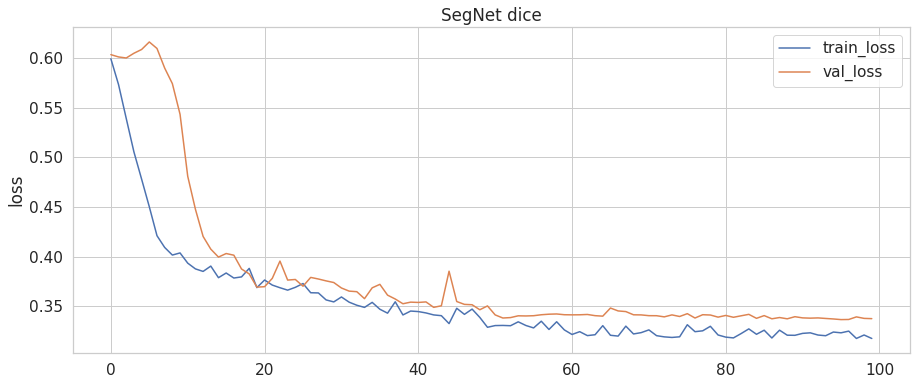

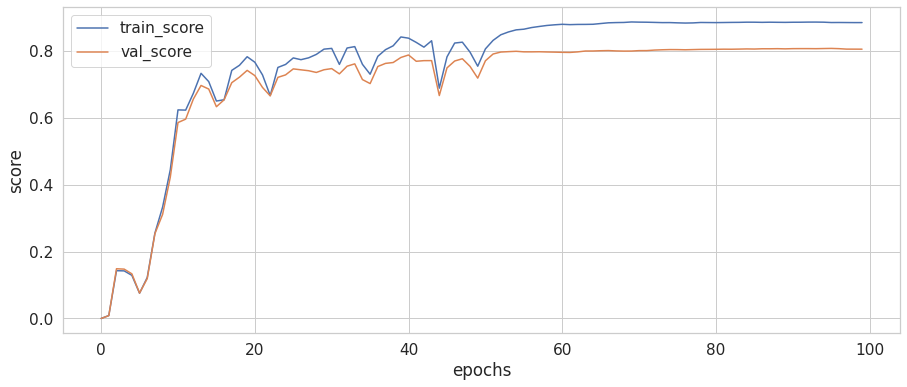

In [115]:
plot_history(history_segnet_dice, title='SegNet dice')

###Focal loss

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf) 

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


In [117]:
def focal_loss(input, target, eps=1e-8, gamma=2):

    inputs = torch.clamp(input.sigmoid(), min = eps)
    alfa = torch.clamp((1 - inputs), min = eps)

    focal = -(alfa**gamma * target * torch.log(inputs) + \
               (1-target) * torch.log(alfa))
    return torch.mean(focal)

In [118]:
model = SegNet().to(device)

max_epochs = 100

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, betas=(0.9, 0.999), weight_decay=0.01)

history_segnet_focal = train(model, optimizer, focal_loss, max_epochs, data_tr, data_val, metric = iou_pytorch)

epoch:   1%|          | 1/100 [00:00<01:26,  1.14it/s]


Epoch 001 train_loss: 0.5793 val_loss 0.5497     train_score 0.3318 val_score 0.3379


epoch:   2%|▏         | 2/100 [00:01<01:25,  1.15it/s]


Epoch 002 train_loss: 0.5515 val_loss 0.5424     train_score 0.3318 val_score 0.3379


epoch:   3%|▎         | 3/100 [00:02<01:24,  1.15it/s]


Epoch 003 train_loss: 0.5403 val_loss 0.5370     train_score 0.3318 val_score 0.3379


epoch:   4%|▍         | 4/100 [00:03<01:23,  1.15it/s]


Epoch 004 train_loss: 0.5362 val_loss 0.5321     train_score 0.3318 val_score 0.3379


epoch:   5%|▌         | 5/100 [00:04<01:22,  1.15it/s]


Epoch 005 train_loss: 0.5299 val_loss 0.5292     train_score 0.3318 val_score 0.3379


epoch:   6%|▌         | 6/100 [00:05<01:21,  1.16it/s]


Epoch 006 train_loss: 0.5249 val_loss 0.5263     train_score 0.3318 val_score 0.3379


epoch:   7%|▋         | 7/100 [00:06<01:20,  1.16it/s]


Epoch 007 train_loss: 0.5215 val_loss 0.5240     train_score 0.3318 val_score 0.3379


epoch:   8%|▊         | 8/100 [00:06<01:19,  1.16it/s]


Epoch 008 train_loss: 0.5193 val_loss 0.5212     train_score 0.3318 val_score 0.3379


epoch:   9%|▉         | 9/100 [00:07<01:18,  1.16it/s]


Epoch 009 train_loss: 0.5175 val_loss 0.5187     train_score 0.3318 val_score 0.3380


epoch:  10%|█         | 10/100 [00:08<01:17,  1.16it/s]


Epoch 010 train_loss: 0.5160 val_loss 0.5165     train_score 0.0002 val_score 0.0002


epoch:  11%|█         | 11/100 [00:09<01:16,  1.16it/s]


Epoch 011 train_loss: 0.5154 val_loss 0.5148     train_score 0.0000 val_score 0.0000


epoch:  12%|█▏        | 12/100 [00:10<01:15,  1.16it/s]


Epoch 012 train_loss: 0.5142 val_loss 0.5136     train_score 0.0000 val_score 0.0000


epoch:  13%|█▎        | 13/100 [00:11<01:15,  1.16it/s]


Epoch 013 train_loss: 0.5142 val_loss 0.5128     train_score 0.0000 val_score 0.0000


epoch:  14%|█▍        | 14/100 [00:12<01:14,  1.16it/s]


Epoch 014 train_loss: 0.5132 val_loss 0.5110     train_score 0.0000 val_score 0.0000


epoch:  15%|█▌        | 15/100 [00:12<01:13,  1.16it/s]


Epoch 015 train_loss: 0.5117 val_loss 0.5094     train_score 0.0000 val_score 0.0000


epoch:  16%|█▌        | 16/100 [00:13<01:12,  1.16it/s]


Epoch 016 train_loss: 0.5129 val_loss 0.5075     train_score 0.0001 val_score 0.0000


epoch:  17%|█▋        | 17/100 [00:14<01:11,  1.16it/s]


Epoch 017 train_loss: 0.5060 val_loss 0.5128     train_score 0.0003 val_score 0.0001


epoch:  18%|█▊        | 18/100 [00:15<01:10,  1.16it/s]


Epoch 018 train_loss: 0.5032 val_loss 0.4975     train_score 0.0138 val_score 0.0168


epoch:  19%|█▉        | 19/100 [00:16<01:10,  1.16it/s]


Epoch 019 train_loss: 0.4934 val_loss 0.5023     train_score 0.4084 val_score 0.4043


epoch:  20%|██        | 20/100 [00:17<01:09,  1.16it/s]


Epoch 020 train_loss: 0.4721 val_loss 0.4681     train_score 0.4593 val_score 0.4630


epoch:  21%|██        | 21/100 [00:18<01:08,  1.16it/s]


Epoch 021 train_loss: 0.4439 val_loss 0.5791     train_score 0.3330 val_score 0.3393


epoch:  22%|██▏       | 22/100 [00:19<01:07,  1.16it/s]


Epoch 022 train_loss: 0.4130 val_loss 0.6293     train_score 0.3344 val_score 0.3417


epoch:  23%|██▎       | 23/100 [00:19<01:06,  1.16it/s]


Epoch 023 train_loss: 0.3693 val_loss 0.7041     train_score 0.3336 val_score 0.3411


epoch:  24%|██▍       | 24/100 [00:20<01:05,  1.16it/s]


Epoch 024 train_loss: 0.3656 val_loss 0.6841     train_score 0.3359 val_score 0.3434


epoch:  25%|██▌       | 25/100 [00:21<01:04,  1.16it/s]


Epoch 025 train_loss: 0.3339 val_loss 0.7201     train_score 0.3327 val_score 0.3390


epoch:  26%|██▌       | 26/100 [00:22<01:03,  1.16it/s]


Epoch 026 train_loss: 0.3371 val_loss 0.7337     train_score 0.3401 val_score 0.3470


epoch:  27%|██▋       | 27/100 [00:23<01:02,  1.16it/s]


Epoch 027 train_loss: 0.3367 val_loss 0.5920     train_score 0.4022 val_score 0.4181


epoch:  28%|██▊       | 28/100 [00:24<01:02,  1.16it/s]


Epoch 028 train_loss: 0.3314 val_loss 0.6794     train_score 0.3911 val_score 0.3907


epoch:  29%|██▉       | 29/100 [00:25<01:01,  1.16it/s]


Epoch 029 train_loss: 0.3227 val_loss 0.6268     train_score 0.4380 val_score 0.4494


epoch:  30%|███       | 30/100 [00:25<01:00,  1.16it/s]


Epoch 030 train_loss: 0.3094 val_loss 0.5041     train_score 0.5275 val_score 0.5359


epoch:  31%|███       | 31/100 [00:26<00:59,  1.16it/s]


Epoch 031 train_loss: 0.3097 val_loss 0.5141     train_score 0.5249 val_score 0.5381


epoch:  32%|███▏      | 32/100 [00:27<00:58,  1.16it/s]


Epoch 032 train_loss: 0.3028 val_loss 0.6735     train_score 0.4386 val_score 0.4461


epoch:  33%|███▎      | 33/100 [00:28<00:57,  1.16it/s]


Epoch 033 train_loss: 0.3021 val_loss 0.6302     train_score 0.4533 val_score 0.4667


epoch:  34%|███▍      | 34/100 [00:29<00:56,  1.16it/s]


Epoch 034 train_loss: 0.2969 val_loss 0.3884     train_score 0.6602 val_score 0.6519


epoch:  35%|███▌      | 35/100 [00:30<00:56,  1.16it/s]


Epoch 035 train_loss: 0.3026 val_loss 0.3285     train_score 0.7038 val_score 0.6827


epoch:  36%|███▌      | 36/100 [00:31<00:55,  1.16it/s]


Epoch 036 train_loss: 0.2952 val_loss 0.4242     train_score 0.5827 val_score 0.6012


epoch:  37%|███▋      | 37/100 [00:31<00:54,  1.16it/s]


Epoch 037 train_loss: 0.3024 val_loss 0.3610     train_score 0.7047 val_score 0.6890


epoch:  38%|███▊      | 38/100 [00:32<00:53,  1.16it/s]


Epoch 038 train_loss: 0.2929 val_loss 0.3452     train_score 0.7130 val_score 0.7006


epoch:  39%|███▉      | 39/100 [00:33<00:52,  1.16it/s]


Epoch 039 train_loss: 0.2954 val_loss 0.3369     train_score 0.7110 val_score 0.6804


epoch:  40%|████      | 40/100 [00:34<00:51,  1.16it/s]


Epoch 040 train_loss: 0.2870 val_loss 0.3145     train_score 0.6694 val_score 0.6243


epoch:  41%|████      | 41/100 [00:35<00:51,  1.16it/s]


Epoch 041 train_loss: 0.2883 val_loss 0.3048     train_score 0.6672 val_score 0.6305


epoch:  42%|████▏     | 42/100 [00:36<00:50,  1.15it/s]


Epoch 042 train_loss: 0.2829 val_loss 0.3013     train_score 0.7181 val_score 0.6681


epoch:  43%|████▎     | 43/100 [00:37<00:49,  1.15it/s]


Epoch 043 train_loss: 0.2759 val_loss 0.3285     train_score 0.7321 val_score 0.6872


epoch:  44%|████▍     | 44/100 [00:38<00:48,  1.16it/s]


Epoch 044 train_loss: 0.2813 val_loss 0.3499     train_score 0.6921 val_score 0.6768


epoch:  45%|████▌     | 45/100 [00:38<00:47,  1.16it/s]


Epoch 045 train_loss: 0.2817 val_loss 0.4426     train_score 0.6024 val_score 0.6047


epoch:  46%|████▌     | 46/100 [00:39<00:46,  1.16it/s]


Epoch 046 train_loss: 0.2803 val_loss 0.5424     train_score 0.5380 val_score 0.5368


epoch:  47%|████▋     | 47/100 [00:40<00:45,  1.16it/s]


Epoch 047 train_loss: 0.2762 val_loss 0.4857     train_score 0.5665 val_score 0.5761


epoch:  48%|████▊     | 48/100 [00:41<00:44,  1.16it/s]


Epoch 048 train_loss: 0.2708 val_loss 0.2782     train_score 0.7706 val_score 0.7243


epoch:  49%|████▉     | 49/100 [00:42<00:44,  1.16it/s]


Epoch 049 train_loss: 0.2715 val_loss 0.2928     train_score 0.7088 val_score 0.6649


epoch:  50%|█████     | 50/100 [00:43<00:43,  1.16it/s]


Epoch 050 train_loss: 0.2682 val_loss 0.2838     train_score 0.7511 val_score 0.6974


epoch:  51%|█████     | 51/100 [00:44<00:42,  1.16it/s]


Epoch 051 train_loss: 0.2628 val_loss 0.2800     train_score 0.7655 val_score 0.7078


epoch:  52%|█████▏    | 52/100 [00:44<00:41,  1.16it/s]


Epoch 052 train_loss: 0.2642 val_loss 0.2750     train_score 0.7826 val_score 0.7199


epoch:  53%|█████▎    | 53/100 [00:45<00:40,  1.16it/s]


Epoch 053 train_loss: 0.2597 val_loss 0.2734     train_score 0.7933 val_score 0.7281


epoch:  54%|█████▍    | 54/100 [00:46<00:39,  1.16it/s]


Epoch 054 train_loss: 0.2553 val_loss 0.2722     train_score 0.8026 val_score 0.7335


epoch:  55%|█████▌    | 55/100 [00:47<00:38,  1.16it/s]


Epoch 055 train_loss: 0.2594 val_loss 0.2710     train_score 0.8071 val_score 0.7395


epoch:  56%|█████▌    | 56/100 [00:48<00:37,  1.16it/s]


Epoch 056 train_loss: 0.2702 val_loss 0.2712     train_score 0.8088 val_score 0.7456


epoch:  57%|█████▋    | 57/100 [00:49<00:37,  1.16it/s]


Epoch 057 train_loss: 0.2681 val_loss 0.2720     train_score 0.8091 val_score 0.7484


epoch:  58%|█████▊    | 58/100 [00:50<00:36,  1.16it/s]


Epoch 058 train_loss: 0.2629 val_loss 0.2714     train_score 0.8111 val_score 0.7480


epoch:  59%|█████▉    | 59/100 [00:50<00:35,  1.16it/s]


Epoch 059 train_loss: 0.2572 val_loss 0.2707     train_score 0.8123 val_score 0.7483


epoch:  60%|██████    | 60/100 [00:51<00:34,  1.16it/s]


Epoch 060 train_loss: 0.2611 val_loss 0.2704     train_score 0.8137 val_score 0.7482


epoch:  61%|██████    | 61/100 [00:52<00:33,  1.16it/s]


Epoch 061 train_loss: 0.2698 val_loss 0.2690     train_score 0.8145 val_score 0.7511


epoch:  62%|██████▏   | 62/100 [00:53<00:32,  1.16it/s]


Epoch 062 train_loss: 0.2569 val_loss 0.2702     train_score 0.8149 val_score 0.7516


epoch:  63%|██████▎   | 63/100 [00:54<00:31,  1.16it/s]


Epoch 063 train_loss: 0.2590 val_loss 0.2713     train_score 0.8142 val_score 0.7510


epoch:  64%|██████▍   | 64/100 [00:55<00:31,  1.16it/s]


Epoch 064 train_loss: 0.2624 val_loss 0.2728     train_score 0.8135 val_score 0.7529


epoch:  65%|██████▌   | 65/100 [00:56<00:30,  1.16it/s]


Epoch 065 train_loss: 0.2759 val_loss 0.2757     train_score 0.8123 val_score 0.7518


epoch:  66%|██████▌   | 66/100 [00:57<00:29,  1.16it/s]


Epoch 066 train_loss: 0.2566 val_loss 0.2743     train_score 0.8161 val_score 0.7536


epoch:  67%|██████▋   | 67/100 [00:57<00:28,  1.15it/s]


Epoch 067 train_loss: 0.2716 val_loss 0.2727     train_score 0.8195 val_score 0.7559


epoch:  68%|██████▊   | 68/100 [00:58<00:27,  1.16it/s]


Epoch 068 train_loss: 0.2549 val_loss 0.2702     train_score 0.8221 val_score 0.7551


epoch:  69%|██████▉   | 69/100 [00:59<00:26,  1.16it/s]


Epoch 069 train_loss: 0.2589 val_loss 0.2676     train_score 0.8231 val_score 0.7532


epoch:  70%|███████   | 70/100 [01:00<00:25,  1.16it/s]


Epoch 070 train_loss: 0.2601 val_loss 0.2674     train_score 0.8221 val_score 0.7536


epoch:  71%|███████   | 71/100 [01:01<00:25,  1.16it/s]


Epoch 071 train_loss: 0.2510 val_loss 0.2672     train_score 0.8220 val_score 0.7530


epoch:  72%|███████▏  | 72/100 [01:02<00:24,  1.16it/s]


Epoch 072 train_loss: 0.2556 val_loss 0.2671     train_score 0.8232 val_score 0.7514


epoch:  73%|███████▎  | 73/100 [01:03<00:23,  1.16it/s]


Epoch 073 train_loss: 0.2612 val_loss 0.2677     train_score 0.8244 val_score 0.7499


epoch:  74%|███████▍  | 74/100 [01:03<00:22,  1.16it/s]


Epoch 074 train_loss: 0.2525 val_loss 0.2686     train_score 0.8245 val_score 0.7504


epoch:  75%|███████▌  | 75/100 [01:04<00:21,  1.16it/s]


Epoch 075 train_loss: 0.2497 val_loss 0.2682     train_score 0.8253 val_score 0.7504


epoch:  76%|███████▌  | 76/100 [01:05<00:20,  1.16it/s]


Epoch 076 train_loss: 0.2608 val_loss 0.2685     train_score 0.8251 val_score 0.7506


epoch:  77%|███████▋  | 77/100 [01:06<00:19,  1.16it/s]


Epoch 077 train_loss: 0.2557 val_loss 0.2680     train_score 0.8257 val_score 0.7511


epoch:  78%|███████▊  | 78/100 [01:07<00:18,  1.16it/s]


Epoch 078 train_loss: 0.2561 val_loss 0.2688     train_score 0.8252 val_score 0.7513


epoch:  79%|███████▉  | 79/100 [01:08<00:18,  1.16it/s]


Epoch 079 train_loss: 0.2519 val_loss 0.2686     train_score 0.8264 val_score 0.7517


epoch:  80%|████████  | 80/100 [01:09<00:17,  1.16it/s]


Epoch 080 train_loss: 0.2677 val_loss 0.2687     train_score 0.8262 val_score 0.7518


epoch:  81%|████████  | 81/100 [01:09<00:16,  1.16it/s]


Epoch 081 train_loss: 0.2532 val_loss 0.2680     train_score 0.8271 val_score 0.7513


epoch:  82%|████████▏ | 82/100 [01:10<00:15,  1.15it/s]


Epoch 082 train_loss: 0.2534 val_loss 0.2679     train_score 0.8273 val_score 0.7516


epoch:  83%|████████▎ | 83/100 [01:11<00:14,  1.16it/s]


Epoch 083 train_loss: 0.2664 val_loss 0.2666     train_score 0.8283 val_score 0.7524


epoch:  84%|████████▍ | 84/100 [01:12<00:13,  1.16it/s]


Epoch 084 train_loss: 0.2591 val_loss 0.2672     train_score 0.8279 val_score 0.7524


epoch:  85%|████████▌ | 85/100 [01:13<00:12,  1.16it/s]


Epoch 085 train_loss: 0.2595 val_loss 0.2683     train_score 0.8274 val_score 0.7517


epoch:  86%|████████▌ | 86/100 [01:14<00:12,  1.16it/s]


Epoch 086 train_loss: 0.2678 val_loss 0.2667     train_score 0.8285 val_score 0.7523


epoch:  87%|████████▋ | 87/100 [01:15<00:11,  1.16it/s]


Epoch 087 train_loss: 0.2563 val_loss 0.2666     train_score 0.8281 val_score 0.7528


epoch:  88%|████████▊ | 88/100 [01:16<00:10,  1.16it/s]


Epoch 088 train_loss: 0.2569 val_loss 0.2670     train_score 0.8282 val_score 0.7523


epoch:  89%|████████▉ | 89/100 [01:16<00:09,  1.16it/s]


Epoch 089 train_loss: 0.2572 val_loss 0.2672     train_score 0.8282 val_score 0.7510


epoch:  90%|█████████ | 90/100 [01:17<00:08,  1.16it/s]


Epoch 090 train_loss: 0.2647 val_loss 0.2673     train_score 0.8282 val_score 0.7514


epoch:  91%|█████████ | 91/100 [01:18<00:07,  1.16it/s]


Epoch 091 train_loss: 0.2524 val_loss 0.2676     train_score 0.8279 val_score 0.7521


epoch:  92%|█████████▏| 92/100 [01:19<00:06,  1.16it/s]


Epoch 092 train_loss: 0.2578 val_loss 0.2675     train_score 0.8281 val_score 0.7518


epoch:  93%|█████████▎| 93/100 [01:20<00:06,  1.16it/s]


Epoch 093 train_loss: 0.2505 val_loss 0.2668     train_score 0.8284 val_score 0.7524


epoch:  94%|█████████▍| 94/100 [01:21<00:05,  1.16it/s]


Epoch 094 train_loss: 0.2555 val_loss 0.2674     train_score 0.8283 val_score 0.7520


epoch:  95%|█████████▌| 95/100 [01:22<00:04,  1.16it/s]


Epoch 095 train_loss: 0.2564 val_loss 0.2666     train_score 0.8285 val_score 0.7521


epoch:  96%|█████████▌| 96/100 [01:22<00:03,  1.16it/s]


Epoch 096 train_loss: 0.2516 val_loss 0.2662     train_score 0.8285 val_score 0.7521


epoch:  97%|█████████▋| 97/100 [01:23<00:02,  1.16it/s]


Epoch 097 train_loss: 0.2549 val_loss 0.2657     train_score 0.8288 val_score 0.7509


epoch:  98%|█████████▊| 98/100 [01:24<00:01,  1.16it/s]


Epoch 098 train_loss: 0.2536 val_loss 0.2657     train_score 0.8290 val_score 0.7511


epoch:  99%|█████████▉| 99/100 [01:25<00:00,  1.16it/s]


Epoch 099 train_loss: 0.2559 val_loss 0.2667     train_score 0.8291 val_score 0.7518


epoch: 100%|██████████| 100/100 [01:26<00:00,  1.16it/s]


Epoch 100 train_loss: 0.2520 val_loss 0.2669     train_score 0.8288 val_score 0.7512


In [119]:
score_segnet_focal = score_model(model, iou_pytorch, data_ts)
score_segnet_focal

0.7601974010467529

# U-Net [2 балла]

## [**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

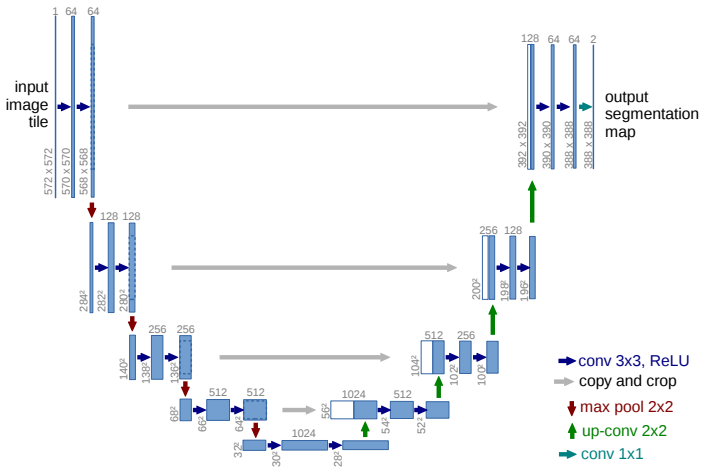

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [63]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)     
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU() 
        )
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, return_indices=True)
        
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU() 
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, return_indices=True)

        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, return_indices=True)

        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU() 
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, return_indices=True)
        
        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=1, padding=0),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=1, padding=0),
            nn.BatchNorm2d(128),
            nn.ReLU() 
        )

        # decoder (upsampling)
        self.upsample0 = nn.MaxUnpool2d(kernel_size=2, stride=2, padding=0) 
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(128*2, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.upsample1 = nn.MaxUnpool2d(kernel_size=2, stride=2, padding=0) 
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(64*2, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )

        self.upsample2 = nn.MaxUnpool2d(kernel_size=2, stride=2, padding=0) 
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(32*2, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU()
        )
        self.upsample3 = nn.MaxUnpool2d(kernel_size=2, stride=2, padding=0) 
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(16*2, 1, kernel_size=3, padding=1),
            nn.BatchNorm2d(1),
            nn.ReLU(),
            nn.Conv2d(1, 1, kernel_size=3, padding=1),
            nn.BatchNorm2d(1),
            nn.ReLU()
        )

    def forward(self, x):
        # encoder
        x0 = self.enc_conv0(x)
        e0, i0 = self.pool0(x0)
        
        x1 = self.enc_conv1(e0)
        e1, i1 = self.pool1(x1)
        
        x2 = self.enc_conv2(e1)        
        e2, i2 = self.pool2(x2)
        
        x3 = self.enc_conv3(e2)
        e3, i3 = self.pool3(x3)
                
        # bottleneck
        b = self.bottleneck_conv(e3)

        # decoder

        d0 = self.dec_conv0(torch.cat([self.upsample0(b, i3), x3], 1))
        d1 = self.dec_conv1(torch.cat([self.upsample1(d0, i2), x2], 1))        
        d2 = self.dec_conv2(torch.cat([self.upsample2(d1, i1), x1], 1))        
        d3 = self.dec_conv3(torch.cat([self.upsample3(d2, i0), x0], 1))
        
        return d3

In [120]:
model = UNet().to(device)

max_epochs = 100

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, betas=(0.9, 0.999), weight_decay=0.01)

history_unet_bce = train(model, optimizer, bce_loss, max_epochs, data_tr, data_val, metric = iou_pytorch)

epoch:   1%|          | 1/100 [00:00<01:30,  1.09it/s]


Epoch 001 train_loss: 0.7484 val_loss 0.7153     train_score 0.3318 val_score 0.3379


epoch:   2%|▏         | 2/100 [00:01<01:29,  1.09it/s]


Epoch 002 train_loss: 0.6863 val_loss 0.7117     train_score 0.3318 val_score 0.3379


epoch:   3%|▎         | 3/100 [00:02<01:28,  1.09it/s]


Epoch 003 train_loss: 0.6581 val_loss 0.7060     train_score 0.3318 val_score 0.3379


epoch:   4%|▍         | 4/100 [00:03<01:28,  1.09it/s]


Epoch 004 train_loss: 0.6444 val_loss 0.7022     train_score 0.3334 val_score 0.3401


epoch:   5%|▌         | 5/100 [00:04<01:27,  1.09it/s]


Epoch 005 train_loss: 0.6431 val_loss 0.6981     train_score 0.3261 val_score 0.3384


epoch:   6%|▌         | 6/100 [00:05<01:26,  1.09it/s]


Epoch 006 train_loss: 0.6367 val_loss 0.6936     train_score 0.3188 val_score 0.3348


epoch:   7%|▋         | 7/100 [00:06<01:25,  1.08it/s]


Epoch 007 train_loss: 0.6399 val_loss 0.6887     train_score 0.0511 val_score 0.0369


epoch:   8%|▊         | 8/100 [00:07<01:24,  1.08it/s]


Epoch 008 train_loss: 0.6344 val_loss 0.6806     train_score 0.1077 val_score 0.1043


epoch:   9%|▉         | 9/100 [00:08<01:23,  1.08it/s]


Epoch 009 train_loss: 0.6357 val_loss 0.6669     train_score 0.2026 val_score 0.1975


epoch:  10%|█         | 10/100 [00:09<01:22,  1.08it/s]


Epoch 010 train_loss: 0.6325 val_loss 0.6561     train_score 0.3216 val_score 0.3158


epoch:  11%|█         | 11/100 [00:10<01:22,  1.08it/s]


Epoch 011 train_loss: 0.6330 val_loss 0.6510     train_score 0.3162 val_score 0.3081


epoch:  12%|█▏        | 12/100 [00:11<01:21,  1.08it/s]


Epoch 012 train_loss: 0.6301 val_loss 0.6458     train_score 0.3357 val_score 0.3208


epoch:  13%|█▎        | 13/100 [00:11<01:20,  1.09it/s]


Epoch 013 train_loss: 0.6298 val_loss 0.6428     train_score 0.3517 val_score 0.3382


epoch:  14%|█▍        | 14/100 [00:12<01:19,  1.09it/s]


Epoch 014 train_loss: 0.6275 val_loss 0.6469     train_score 0.3660 val_score 0.3563


epoch:  15%|█▌        | 15/100 [00:13<01:18,  1.08it/s]


Epoch 015 train_loss: 0.6323 val_loss 0.6494     train_score 0.3434 val_score 0.3345


epoch:  16%|█▌        | 16/100 [00:14<01:17,  1.08it/s]


Epoch 016 train_loss: 0.6288 val_loss 0.6291     train_score 0.4046 val_score 0.3903


epoch:  17%|█▋        | 17/100 [00:15<01:16,  1.08it/s]


Epoch 017 train_loss: 0.6293 val_loss 0.6313     train_score 0.3832 val_score 0.3608


epoch:  18%|█▊        | 18/100 [00:16<01:15,  1.08it/s]


Epoch 018 train_loss: 0.6278 val_loss 0.6303     train_score 0.3889 val_score 0.3755


epoch:  19%|█▉        | 19/100 [00:17<01:14,  1.08it/s]


Epoch 019 train_loss: 0.6252 val_loss 0.6283     train_score 0.4090 val_score 0.3933


epoch:  20%|██        | 20/100 [00:18<01:13,  1.08it/s]


Epoch 020 train_loss: 0.6225 val_loss 0.6272     train_score 0.4166 val_score 0.3941


epoch:  21%|██        | 21/100 [00:19<01:13,  1.08it/s]


Epoch 021 train_loss: 0.6254 val_loss 0.6375     train_score 0.3912 val_score 0.3741


epoch:  22%|██▏       | 22/100 [00:20<01:12,  1.08it/s]


Epoch 022 train_loss: 0.6235 val_loss 0.6327     train_score 0.3844 val_score 0.3822


epoch:  23%|██▎       | 23/100 [00:21<01:11,  1.08it/s]


Epoch 023 train_loss: 0.6212 val_loss 0.6283     train_score 0.4133 val_score 0.3942


epoch:  24%|██▍       | 24/100 [00:22<01:10,  1.08it/s]


Epoch 024 train_loss: 0.6228 val_loss 0.6319     train_score 0.3921 val_score 0.3650


epoch:  25%|██▌       | 25/100 [00:23<01:09,  1.08it/s]


Epoch 025 train_loss: 0.6242 val_loss 0.6374     train_score 0.3584 val_score 0.3594


epoch:  26%|██▌       | 26/100 [00:23<01:08,  1.08it/s]


Epoch 026 train_loss: 0.6276 val_loss 0.6341     train_score 0.4014 val_score 0.3757


epoch:  27%|██▋       | 27/100 [00:24<01:07,  1.08it/s]


Epoch 027 train_loss: 0.6226 val_loss 0.6364     train_score 0.3432 val_score 0.3348


epoch:  28%|██▊       | 28/100 [00:25<01:06,  1.08it/s]


Epoch 028 train_loss: 0.6271 val_loss 0.6321     train_score 0.3812 val_score 0.3816


epoch:  29%|██▉       | 29/100 [00:26<01:05,  1.08it/s]


Epoch 029 train_loss: 0.6216 val_loss 0.6319     train_score 0.4209 val_score 0.4147


epoch:  30%|███       | 30/100 [00:27<01:04,  1.08it/s]


Epoch 030 train_loss: 0.6204 val_loss 0.6278     train_score 0.4166 val_score 0.3962


epoch:  31%|███       | 31/100 [00:28<01:03,  1.08it/s]


Epoch 031 train_loss: 0.6184 val_loss 0.6253     train_score 0.4029 val_score 0.3944


epoch:  32%|███▏      | 32/100 [00:29<01:02,  1.08it/s]


Epoch 032 train_loss: 0.6185 val_loss 0.6228     train_score 0.4300 val_score 0.4173


epoch:  33%|███▎      | 33/100 [00:30<01:01,  1.08it/s]


Epoch 033 train_loss: 0.6174 val_loss 0.6249     train_score 0.4323 val_score 0.4225


epoch:  34%|███▍      | 34/100 [00:31<01:00,  1.08it/s]


Epoch 034 train_loss: 0.6159 val_loss 0.6229     train_score 0.4385 val_score 0.4183


epoch:  35%|███▌      | 35/100 [00:32<01:00,  1.08it/s]


Epoch 035 train_loss: 0.6175 val_loss 0.6226     train_score 0.4389 val_score 0.4173


epoch:  36%|███▌      | 36/100 [00:33<00:59,  1.08it/s]


Epoch 036 train_loss: 0.6150 val_loss 0.6299     train_score 0.4410 val_score 0.4049


epoch:  37%|███▋      | 37/100 [00:34<00:58,  1.08it/s]


Epoch 037 train_loss: 0.6167 val_loss 0.6268     train_score 0.4997 val_score 0.4683


epoch:  38%|███▊      | 38/100 [00:35<00:57,  1.09it/s]


Epoch 038 train_loss: 0.6130 val_loss 0.6028     train_score 0.6249 val_score 0.6325


epoch:  39%|███▉      | 39/100 [00:35<00:56,  1.09it/s]


Epoch 039 train_loss: 0.5990 val_loss 0.5765     train_score 0.7125 val_score 0.7259


epoch:  40%|████      | 40/100 [00:36<00:55,  1.09it/s]


Epoch 040 train_loss: 0.5858 val_loss 0.5794     train_score 0.7399 val_score 0.7172


epoch:  41%|████      | 41/100 [00:37<00:54,  1.08it/s]


Epoch 041 train_loss: 0.5774 val_loss 0.5563     train_score 0.7631 val_score 0.7498


epoch:  42%|████▏     | 42/100 [00:38<00:53,  1.08it/s]


Epoch 042 train_loss: 0.5680 val_loss 0.5798     train_score 0.7628 val_score 0.7424


epoch:  43%|████▎     | 43/100 [00:39<00:52,  1.08it/s]


Epoch 043 train_loss: 0.5706 val_loss 0.5768     train_score 0.7549 val_score 0.7239


epoch:  44%|████▍     | 44/100 [00:40<00:51,  1.08it/s]


Epoch 044 train_loss: 0.5685 val_loss 0.5670     train_score 0.7528 val_score 0.7365


epoch:  45%|████▌     | 45/100 [00:41<00:50,  1.08it/s]


Epoch 045 train_loss: 0.5668 val_loss 0.5631     train_score 0.7925 val_score 0.7641


epoch:  46%|████▌     | 46/100 [00:42<00:49,  1.08it/s]


Epoch 046 train_loss: 0.5635 val_loss 0.5580     train_score 0.8173 val_score 0.7937


epoch:  47%|████▋     | 47/100 [00:43<00:48,  1.08it/s]


Epoch 047 train_loss: 0.5617 val_loss 0.5592     train_score 0.8349 val_score 0.8014


epoch:  48%|████▊     | 48/100 [00:44<00:47,  1.08it/s]


Epoch 048 train_loss: 0.5573 val_loss 0.5695     train_score 0.8137 val_score 0.7637


epoch:  49%|████▉     | 49/100 [00:45<00:47,  1.08it/s]


Epoch 049 train_loss: 0.5574 val_loss 0.5655     train_score 0.8203 val_score 0.8001


epoch:  50%|█████     | 50/100 [00:46<00:46,  1.09it/s]


Epoch 050 train_loss: 0.5661 val_loss 0.5689     train_score 0.7759 val_score 0.7367


epoch:  51%|█████     | 51/100 [00:47<00:45,  1.09it/s]


Epoch 051 train_loss: 0.5630 val_loss 0.5662     train_score 0.7951 val_score 0.7516


epoch:  52%|█████▏    | 52/100 [00:47<00:44,  1.09it/s]


Epoch 052 train_loss: 0.5589 val_loss 0.5636     train_score 0.8120 val_score 0.7674


epoch:  53%|█████▎    | 53/100 [00:48<00:43,  1.08it/s]


Epoch 053 train_loss: 0.5586 val_loss 0.5610     train_score 0.8274 val_score 0.7792


epoch:  54%|█████▍    | 54/100 [00:49<00:42,  1.08it/s]


Epoch 054 train_loss: 0.5524 val_loss 0.5592     train_score 0.8423 val_score 0.7924


epoch:  55%|█████▌    | 55/100 [00:50<00:41,  1.08it/s]


Epoch 055 train_loss: 0.5545 val_loss 0.5579     train_score 0.8511 val_score 0.8030


epoch:  56%|█████▌    | 56/100 [00:51<00:40,  1.08it/s]


Epoch 056 train_loss: 0.5584 val_loss 0.5596     train_score 0.8536 val_score 0.8024


epoch:  57%|█████▋    | 57/100 [00:52<00:39,  1.08it/s]


Epoch 057 train_loss: 0.5535 val_loss 0.5625     train_score 0.8529 val_score 0.7961


epoch:  58%|█████▊    | 58/100 [00:53<00:38,  1.08it/s]


Epoch 058 train_loss: 0.5594 val_loss 0.5631     train_score 0.8493 val_score 0.7938


epoch:  59%|█████▉    | 59/100 [00:54<00:37,  1.08it/s]


Epoch 059 train_loss: 0.5511 val_loss 0.5604     train_score 0.8555 val_score 0.8009


epoch:  60%|██████    | 60/100 [00:55<00:36,  1.08it/s]


Epoch 060 train_loss: 0.5504 val_loss 0.5564     train_score 0.8656 val_score 0.8106


epoch:  61%|██████    | 61/100 [00:56<00:36,  1.08it/s]


Epoch 061 train_loss: 0.5496 val_loss 0.5533     train_score 0.8738 val_score 0.8181


epoch:  62%|██████▏   | 62/100 [00:57<00:35,  1.08it/s]


Epoch 062 train_loss: 0.5509 val_loss 0.5512     train_score 0.8764 val_score 0.8209


epoch:  63%|██████▎   | 63/100 [00:58<00:34,  1.08it/s]


Epoch 063 train_loss: 0.5532 val_loss 0.5506     train_score 0.8740 val_score 0.8208


epoch:  64%|██████▍   | 64/100 [00:59<00:33,  1.08it/s]


Epoch 064 train_loss: 0.5467 val_loss 0.5512     train_score 0.8737 val_score 0.8204


epoch:  65%|██████▌   | 65/100 [00:59<00:32,  1.08it/s]


Epoch 065 train_loss: 0.5465 val_loss 0.5519     train_score 0.8771 val_score 0.8212


epoch:  66%|██████▌   | 66/100 [01:00<00:31,  1.08it/s]


Epoch 066 train_loss: 0.5503 val_loss 0.5519     train_score 0.8812 val_score 0.8225


epoch:  67%|██████▋   | 67/100 [01:01<00:30,  1.08it/s]


Epoch 067 train_loss: 0.5469 val_loss 0.5529     train_score 0.8814 val_score 0.8226


epoch:  68%|██████▊   | 68/100 [01:02<00:29,  1.08it/s]


Epoch 068 train_loss: 0.5467 val_loss 0.5529     train_score 0.8822 val_score 0.8236


epoch:  69%|██████▉   | 69/100 [01:03<00:28,  1.08it/s]


Epoch 069 train_loss: 0.5506 val_loss 0.5517     train_score 0.8836 val_score 0.8238


epoch:  70%|███████   | 70/100 [01:04<00:27,  1.08it/s]


Epoch 070 train_loss: 0.5450 val_loss 0.5517     train_score 0.8844 val_score 0.8240


epoch:  71%|███████   | 71/100 [01:05<00:26,  1.08it/s]


Epoch 071 train_loss: 0.5446 val_loss 0.5511     train_score 0.8854 val_score 0.8239


epoch:  72%|███████▏  | 72/100 [01:06<00:25,  1.08it/s]


Epoch 072 train_loss: 0.5442 val_loss 0.5511     train_score 0.8858 val_score 0.8239


epoch:  73%|███████▎  | 73/100 [01:07<00:24,  1.08it/s]


Epoch 073 train_loss: 0.5455 val_loss 0.5510     train_score 0.8859 val_score 0.8236


epoch:  74%|███████▍  | 74/100 [01:08<00:24,  1.08it/s]


Epoch 074 train_loss: 0.5526 val_loss 0.5509     train_score 0.8859 val_score 0.8230


epoch:  75%|███████▌  | 75/100 [01:09<00:23,  1.08it/s]


Epoch 075 train_loss: 0.5452 val_loss 0.5510     train_score 0.8860 val_score 0.8230


epoch:  76%|███████▌  | 76/100 [01:10<00:22,  1.08it/s]


Epoch 076 train_loss: 0.5444 val_loss 0.5512     train_score 0.8858 val_score 0.8230


epoch:  77%|███████▋  | 77/100 [01:11<00:21,  1.08it/s]


Epoch 077 train_loss: 0.5447 val_loss 0.5513     train_score 0.8859 val_score 0.8231


epoch:  78%|███████▊  | 78/100 [01:12<00:20,  1.08it/s]


Epoch 078 train_loss: 0.5468 val_loss 0.5511     train_score 0.8864 val_score 0.8233


epoch:  79%|███████▉  | 79/100 [01:12<00:19,  1.08it/s]


Epoch 079 train_loss: 0.5454 val_loss 0.5512     train_score 0.8865 val_score 0.8235


epoch:  80%|████████  | 80/100 [01:13<00:18,  1.08it/s]


Epoch 080 train_loss: 0.5457 val_loss 0.5513     train_score 0.8863 val_score 0.8233


epoch:  81%|████████  | 81/100 [01:14<00:17,  1.08it/s]


Epoch 081 train_loss: 0.5483 val_loss 0.5512     train_score 0.8865 val_score 0.8233


epoch:  82%|████████▏ | 82/100 [01:15<00:16,  1.08it/s]


Epoch 082 train_loss: 0.5470 val_loss 0.5513     train_score 0.8865 val_score 0.8234


epoch:  83%|████████▎ | 83/100 [01:16<00:15,  1.08it/s]


Epoch 083 train_loss: 0.5478 val_loss 0.5513     train_score 0.8866 val_score 0.8234


epoch:  84%|████████▍ | 84/100 [01:17<00:14,  1.08it/s]


Epoch 084 train_loss: 0.5477 val_loss 0.5512     train_score 0.8868 val_score 0.8235


epoch:  85%|████████▌ | 85/100 [01:18<00:13,  1.08it/s]


Epoch 085 train_loss: 0.5453 val_loss 0.5512     train_score 0.8867 val_score 0.8237


epoch:  86%|████████▌ | 86/100 [01:19<00:12,  1.08it/s]


Epoch 086 train_loss: 0.5436 val_loss 0.5512     train_score 0.8868 val_score 0.8238


epoch:  87%|████████▋ | 87/100 [01:20<00:12,  1.08it/s]


Epoch 087 train_loss: 0.5470 val_loss 0.5511     train_score 0.8869 val_score 0.8239


epoch:  88%|████████▊ | 88/100 [01:21<00:11,  1.08it/s]


Epoch 088 train_loss: 0.5491 val_loss 0.5511     train_score 0.8867 val_score 0.8239


epoch:  89%|████████▉ | 89/100 [01:22<00:10,  1.08it/s]


Epoch 089 train_loss: 0.5463 val_loss 0.5509     train_score 0.8872 val_score 0.8242


epoch:  90%|█████████ | 90/100 [01:23<00:09,  1.08it/s]


Epoch 090 train_loss: 0.5445 val_loss 0.5509     train_score 0.8872 val_score 0.8240


epoch:  91%|█████████ | 91/100 [01:24<00:08,  1.08it/s]


Epoch 091 train_loss: 0.5454 val_loss 0.5509     train_score 0.8871 val_score 0.8239


epoch:  92%|█████████▏| 92/100 [01:24<00:07,  1.08it/s]


Epoch 092 train_loss: 0.5475 val_loss 0.5509     train_score 0.8872 val_score 0.8240


epoch:  93%|█████████▎| 93/100 [01:25<00:06,  1.08it/s]


Epoch 093 train_loss: 0.5467 val_loss 0.5508     train_score 0.8872 val_score 0.8242


epoch:  94%|█████████▍| 94/100 [01:26<00:05,  1.08it/s]


Epoch 094 train_loss: 0.5460 val_loss 0.5509     train_score 0.8873 val_score 0.8244


epoch:  95%|█████████▌| 95/100 [01:27<00:04,  1.08it/s]


Epoch 095 train_loss: 0.5440 val_loss 0.5510     train_score 0.8873 val_score 0.8245


epoch:  96%|█████████▌| 96/100 [01:28<00:03,  1.08it/s]


Epoch 096 train_loss: 0.5441 val_loss 0.5513     train_score 0.8868 val_score 0.8241


epoch:  97%|█████████▋| 97/100 [01:29<00:02,  1.08it/s]


Epoch 097 train_loss: 0.5446 val_loss 0.5513     train_score 0.8866 val_score 0.8238


epoch:  98%|█████████▊| 98/100 [01:30<00:01,  1.08it/s]


Epoch 098 train_loss: 0.5501 val_loss 0.5512     train_score 0.8869 val_score 0.8241


epoch:  99%|█████████▉| 99/100 [01:31<00:00,  1.08it/s]


Epoch 099 train_loss: 0.5431 val_loss 0.5513     train_score 0.8869 val_score 0.8243


epoch: 100%|██████████| 100/100 [01:32<00:00,  1.08it/s]


Epoch 100 train_loss: 0.5438 val_loss 0.5511     train_score 0.8872 val_score 0.8243


In [121]:
score_unet_bce = score_model(model, iou_pytorch, data_ts)
score_unet_bce

0.8438593447208405

In [124]:
model = UNet().to(device)

max_epochs = 100

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, betas=(0.9, 0.999), weight_decay=0.01)

history_unet_dice = train(model, optimizer, dice_loss, max_epochs, data_tr, data_val, metric = iou_pytorch)

epoch:   1%|          | 1/100 [00:00<01:29,  1.11it/s]


Epoch 001 train_loss: 0.5370 val_loss 0.5844     train_score 0.3318 val_score 0.3379


epoch:   2%|▏         | 2/100 [00:01<01:28,  1.10it/s]


Epoch 002 train_loss: 0.4961 val_loss 0.5871     train_score 0.3318 val_score 0.3379


epoch:   3%|▎         | 3/100 [00:02<01:28,  1.10it/s]


Epoch 003 train_loss: 0.4902 val_loss 0.5849     train_score 0.3318 val_score 0.3380


epoch:   4%|▍         | 4/100 [00:03<01:27,  1.10it/s]


Epoch 004 train_loss: 0.4856 val_loss 0.5873     train_score 0.3265 val_score 0.3393


epoch:   5%|▌         | 5/100 [00:04<01:26,  1.10it/s]


Epoch 005 train_loss: 0.4776 val_loss 0.5912     train_score 0.3089 val_score 0.3334


epoch:   6%|▌         | 6/100 [00:05<01:26,  1.09it/s]


Epoch 006 train_loss: 0.4680 val_loss 0.5868     train_score 0.4170 val_score 0.4367


epoch:   7%|▋         | 7/100 [00:06<01:25,  1.09it/s]


Epoch 007 train_loss: 0.4625 val_loss 0.5864     train_score 0.4077 val_score 0.4125


epoch:   8%|▊         | 8/100 [00:07<01:24,  1.09it/s]


Epoch 008 train_loss: 0.4591 val_loss 0.5910     train_score 0.2444 val_score 0.2372


epoch:   9%|▉         | 9/100 [00:08<01:23,  1.09it/s]


Epoch 009 train_loss: 0.4604 val_loss 0.5909     train_score 0.2319 val_score 0.2231


epoch:  10%|█         | 10/100 [00:09<01:22,  1.09it/s]


Epoch 010 train_loss: 0.4637 val_loss 0.5812     train_score 0.2474 val_score 0.2298


epoch:  11%|█         | 11/100 [00:10<01:21,  1.09it/s]


Epoch 011 train_loss: 0.4575 val_loss 0.5405     train_score 0.3371 val_score 0.3739


epoch:  12%|█▏        | 12/100 [00:10<01:20,  1.09it/s]


Epoch 012 train_loss: 0.4506 val_loss 0.5302     train_score 0.3292 val_score 0.3772


epoch:  13%|█▎        | 13/100 [00:11<01:19,  1.09it/s]


Epoch 013 train_loss: 0.4450 val_loss 0.5099     train_score 0.4067 val_score 0.4940


epoch:  14%|█▍        | 14/100 [00:12<01:18,  1.09it/s]


Epoch 014 train_loss: 0.4409 val_loss 0.4790     train_score 0.6156 val_score 0.6337


epoch:  15%|█▌        | 15/100 [00:13<01:17,  1.09it/s]


Epoch 015 train_loss: 0.4413 val_loss 0.4593     train_score 0.7033 val_score 0.6979


epoch:  16%|█▌        | 16/100 [00:14<01:16,  1.09it/s]


Epoch 016 train_loss: 0.4449 val_loss 0.4600     train_score 0.7627 val_score 0.7116


epoch:  17%|█▋        | 17/100 [00:15<01:15,  1.09it/s]


Epoch 017 train_loss: 0.4393 val_loss 0.4546     train_score 0.7807 val_score 0.7250


epoch:  18%|█▊        | 18/100 [00:16<01:15,  1.09it/s]


Epoch 018 train_loss: 0.4448 val_loss 0.4425     train_score 0.7763 val_score 0.7316


epoch:  19%|█▉        | 19/100 [00:17<01:14,  1.09it/s]


Epoch 019 train_loss: 0.4348 val_loss 0.4619     train_score 0.7011 val_score 0.6797


epoch:  20%|██        | 20/100 [00:18<01:13,  1.09it/s]


Epoch 020 train_loss: 0.4366 val_loss 0.4417     train_score 0.7978 val_score 0.7672


epoch:  21%|██        | 21/100 [00:19<01:12,  1.09it/s]


Epoch 021 train_loss: 0.4386 val_loss 0.4547     train_score 0.8047 val_score 0.7491


epoch:  22%|██▏       | 22/100 [00:20<01:11,  1.09it/s]


Epoch 022 train_loss: 0.4374 val_loss 0.4375     train_score 0.8202 val_score 0.7780


epoch:  23%|██▎       | 23/100 [00:21<01:10,  1.09it/s]


Epoch 023 train_loss: 0.4350 val_loss 0.4340     train_score 0.8221 val_score 0.7774


epoch:  24%|██▍       | 24/100 [00:21<01:09,  1.09it/s]


Epoch 024 train_loss: 0.4326 val_loss 0.4430     train_score 0.8063 val_score 0.7526


epoch:  25%|██▌       | 25/100 [00:22<01:08,  1.09it/s]


Epoch 025 train_loss: 0.4335 val_loss 0.4378     train_score 0.8117 val_score 0.7545


epoch:  26%|██▌       | 26/100 [00:23<01:07,  1.09it/s]


Epoch 026 train_loss: 0.4320 val_loss 0.4276     train_score 0.8320 val_score 0.7774


epoch:  27%|██▋       | 27/100 [00:24<01:06,  1.09it/s]


Epoch 027 train_loss: 0.4321 val_loss 0.4269     train_score 0.8329 val_score 0.7738


epoch:  28%|██▊       | 28/100 [00:25<01:05,  1.09it/s]


Epoch 028 train_loss: 0.4318 val_loss 0.4233     train_score 0.8187 val_score 0.7644


epoch:  29%|██▉       | 29/100 [00:26<01:04,  1.09it/s]


Epoch 029 train_loss: 0.4309 val_loss 0.4333     train_score 0.8523 val_score 0.7710


epoch:  30%|███       | 30/100 [00:27<01:04,  1.09it/s]


Epoch 030 train_loss: 0.4282 val_loss 0.4292     train_score 0.8491 val_score 0.7948


epoch:  31%|███       | 31/100 [00:28<01:03,  1.09it/s]


Epoch 031 train_loss: 0.4284 val_loss 0.4286     train_score 0.8401 val_score 0.7828


epoch:  32%|███▏      | 32/100 [00:29<01:02,  1.09it/s]


Epoch 032 train_loss: 0.4268 val_loss 0.4288     train_score 0.8657 val_score 0.8048


epoch:  33%|███▎      | 33/100 [00:30<01:01,  1.09it/s]


Epoch 033 train_loss: 0.4282 val_loss 0.4400     train_score 0.8365 val_score 0.7557


epoch:  34%|███▍      | 34/100 [00:31<01:00,  1.09it/s]


Epoch 034 train_loss: 0.4319 val_loss 0.4311     train_score 0.8532 val_score 0.7691


epoch:  35%|███▌      | 35/100 [00:32<00:59,  1.09it/s]


Epoch 035 train_loss: 0.4240 val_loss 0.4235     train_score 0.8159 val_score 0.7711


epoch:  36%|███▌      | 36/100 [00:32<00:58,  1.09it/s]


Epoch 036 train_loss: 0.4345 val_loss 0.4219     train_score 0.7652 val_score 0.7516


epoch:  37%|███▋      | 37/100 [00:33<00:57,  1.09it/s]


Epoch 037 train_loss: 0.4241 val_loss 0.4221     train_score 0.8280 val_score 0.7852


epoch:  38%|███▊      | 38/100 [00:34<00:56,  1.09it/s]


Epoch 038 train_loss: 0.4251 val_loss 0.4344     train_score 0.8282 val_score 0.7810


epoch:  39%|███▉      | 39/100 [00:35<00:55,  1.09it/s]


Epoch 039 train_loss: 0.4307 val_loss 0.4423     train_score 0.8011 val_score 0.7572


epoch:  40%|████      | 40/100 [00:36<00:55,  1.09it/s]


Epoch 040 train_loss: 0.4199 val_loss 0.4311     train_score 0.8345 val_score 0.7702


epoch:  41%|████      | 41/100 [00:37<00:54,  1.09it/s]


Epoch 041 train_loss: 0.4196 val_loss 0.4257     train_score 0.8709 val_score 0.7837


epoch:  42%|████▏     | 42/100 [00:38<00:53,  1.09it/s]


Epoch 042 train_loss: 0.4257 val_loss 0.4358     train_score 0.8536 val_score 0.7697


epoch:  43%|████▎     | 43/100 [00:39<00:52,  1.09it/s]


Epoch 043 train_loss: 0.4170 val_loss 0.4250     train_score 0.8522 val_score 0.7879


epoch:  44%|████▍     | 44/100 [00:40<00:51,  1.09it/s]


Epoch 044 train_loss: 0.4275 val_loss 0.4229     train_score 0.8640 val_score 0.7884


epoch:  45%|████▌     | 45/100 [00:41<00:50,  1.09it/s]


Epoch 045 train_loss: 0.4234 val_loss 0.4207     train_score 0.8486 val_score 0.7897


epoch:  46%|████▌     | 46/100 [00:42<00:49,  1.09it/s]


Epoch 046 train_loss: 0.4156 val_loss 0.4214     train_score 0.8744 val_score 0.7983


epoch:  47%|████▋     | 47/100 [00:43<00:48,  1.09it/s]


Epoch 047 train_loss: 0.4183 val_loss 0.4168     train_score 0.8783 val_score 0.8064


epoch:  48%|████▊     | 48/100 [00:43<00:47,  1.09it/s]


Epoch 048 train_loss: 0.4166 val_loss 0.4194     train_score 0.8659 val_score 0.8085


epoch:  49%|████▉     | 49/100 [00:44<00:46,  1.09it/s]


Epoch 049 train_loss: 0.4201 val_loss 0.4159     train_score 0.8701 val_score 0.7988


epoch:  50%|█████     | 50/100 [00:45<00:45,  1.09it/s]


Epoch 050 train_loss: 0.4127 val_loss 0.4262     train_score 0.8717 val_score 0.7766


epoch:  51%|█████     | 51/100 [00:46<00:44,  1.09it/s]


Epoch 051 train_loss: 0.4197 val_loss 0.4244     train_score 0.8798 val_score 0.7806


epoch:  52%|█████▏    | 52/100 [00:47<00:43,  1.09it/s]


Epoch 052 train_loss: 0.4161 val_loss 0.4239     train_score 0.8876 val_score 0.7863


epoch:  53%|█████▎    | 53/100 [00:48<00:43,  1.09it/s]


Epoch 053 train_loss: 0.4126 val_loss 0.4226     train_score 0.8911 val_score 0.7895


epoch:  54%|█████▍    | 54/100 [00:49<00:42,  1.09it/s]


Epoch 054 train_loss: 0.4161 val_loss 0.4202     train_score 0.8914 val_score 0.7943


epoch:  55%|█████▌    | 55/100 [00:50<00:41,  1.09it/s]


Epoch 055 train_loss: 0.4155 val_loss 0.4181     train_score 0.8925 val_score 0.8018


epoch:  56%|█████▌    | 56/100 [00:51<00:40,  1.09it/s]


Epoch 056 train_loss: 0.4123 val_loss 0.4168     train_score 0.8948 val_score 0.8053


epoch:  57%|█████▋    | 57/100 [00:52<00:39,  1.09it/s]


Epoch 057 train_loss: 0.4192 val_loss 0.4178     train_score 0.8975 val_score 0.8106


epoch:  58%|█████▊    | 58/100 [00:53<00:38,  1.09it/s]


Epoch 058 train_loss: 0.4129 val_loss 0.4163     train_score 0.8991 val_score 0.8151


epoch:  59%|█████▉    | 59/100 [00:54<00:37,  1.09it/s]


Epoch 059 train_loss: 0.4109 val_loss 0.4149     train_score 0.9011 val_score 0.8182


epoch:  60%|██████    | 60/100 [00:54<00:36,  1.09it/s]


Epoch 060 train_loss: 0.4099 val_loss 0.4145     train_score 0.9022 val_score 0.8176


epoch:  61%|██████    | 61/100 [00:55<00:35,  1.09it/s]


Epoch 061 train_loss: 0.4102 val_loss 0.4190     train_score 0.9021 val_score 0.8162


epoch:  62%|██████▏   | 62/100 [00:56<00:34,  1.09it/s]


Epoch 062 train_loss: 0.4135 val_loss 0.4129     train_score 0.9028 val_score 0.8175


epoch:  63%|██████▎   | 63/100 [00:57<00:33,  1.09it/s]


Epoch 063 train_loss: 0.4083 val_loss 0.4126     train_score 0.9024 val_score 0.8202


epoch:  64%|██████▍   | 64/100 [00:58<00:33,  1.09it/s]


Epoch 064 train_loss: 0.4211 val_loss 0.4124     train_score 0.9032 val_score 0.8218


epoch:  65%|██████▌   | 65/100 [00:59<00:32,  1.09it/s]


Epoch 065 train_loss: 0.4092 val_loss 0.4127     train_score 0.9046 val_score 0.8253


epoch:  66%|██████▌   | 66/100 [01:00<00:31,  1.09it/s]


Epoch 066 train_loss: 0.4113 val_loss 0.4136     train_score 0.9048 val_score 0.8234


epoch:  67%|██████▋   | 67/100 [01:01<00:30,  1.09it/s]


Epoch 067 train_loss: 0.4063 val_loss 0.4116     train_score 0.9039 val_score 0.8227


epoch:  68%|██████▊   | 68/100 [01:02<00:29,  1.09it/s]


Epoch 068 train_loss: 0.4127 val_loss 0.4131     train_score 0.9032 val_score 0.8214


epoch:  69%|██████▉   | 69/100 [01:03<00:28,  1.09it/s]


Epoch 069 train_loss: 0.4086 val_loss 0.4120     train_score 0.9035 val_score 0.8213


epoch:  70%|███████   | 70/100 [01:04<00:27,  1.09it/s]


Epoch 070 train_loss: 0.4102 val_loss 0.4133     train_score 0.9048 val_score 0.8227


epoch:  71%|███████   | 71/100 [01:05<00:26,  1.09it/s]


Epoch 071 train_loss: 0.4082 val_loss 0.4123     train_score 0.9047 val_score 0.8219


epoch:  72%|███████▏  | 72/100 [01:05<00:25,  1.09it/s]


Epoch 072 train_loss: 0.4073 val_loss 0.4124     train_score 0.9050 val_score 0.8215


epoch:  73%|███████▎  | 73/100 [01:06<00:24,  1.09it/s]


Epoch 073 train_loss: 0.4106 val_loss 0.4130     train_score 0.9052 val_score 0.8215


epoch:  74%|███████▍  | 74/100 [01:07<00:23,  1.09it/s]


Epoch 074 train_loss: 0.4113 val_loss 0.4136     train_score 0.9047 val_score 0.8206


epoch:  75%|███████▌  | 75/100 [01:08<00:22,  1.09it/s]


Epoch 075 train_loss: 0.4094 val_loss 0.4125     train_score 0.9051 val_score 0.8206


epoch:  76%|███████▌  | 76/100 [01:09<00:22,  1.09it/s]


Epoch 076 train_loss: 0.4077 val_loss 0.4113     train_score 0.9048 val_score 0.8200


epoch:  77%|███████▋  | 77/100 [01:10<00:21,  1.09it/s]


Epoch 077 train_loss: 0.4109 val_loss 0.4120     train_score 0.9053 val_score 0.8202


epoch:  78%|███████▊  | 78/100 [01:11<00:20,  1.09it/s]


Epoch 078 train_loss: 0.4111 val_loss 0.4118     train_score 0.9054 val_score 0.8204


epoch:  79%|███████▉  | 79/100 [01:12<00:19,  1.09it/s]


Epoch 079 train_loss: 0.4093 val_loss 0.4123     train_score 0.9057 val_score 0.8207


epoch:  80%|████████  | 80/100 [01:13<00:18,  1.09it/s]


Epoch 080 train_loss: 0.4076 val_loss 0.4123     train_score 0.9057 val_score 0.8204


epoch:  81%|████████  | 81/100 [01:14<00:17,  1.09it/s]


Epoch 081 train_loss: 0.4112 val_loss 0.4109     train_score 0.9047 val_score 0.8194


epoch:  82%|████████▏ | 82/100 [01:15<00:16,  1.09it/s]


Epoch 082 train_loss: 0.4089 val_loss 0.4112     train_score 0.9054 val_score 0.8198


epoch:  83%|████████▎ | 83/100 [01:16<00:15,  1.09it/s]


Epoch 083 train_loss: 0.4102 val_loss 0.4117     train_score 0.9058 val_score 0.8200


epoch:  84%|████████▍ | 84/100 [01:17<00:14,  1.09it/s]


Epoch 084 train_loss: 0.4070 val_loss 0.4168     train_score 0.9058 val_score 0.8200


epoch:  85%|████████▌ | 85/100 [01:17<00:13,  1.09it/s]


Epoch 085 train_loss: 0.4153 val_loss 0.4121     train_score 0.9057 val_score 0.8200


epoch:  86%|████████▌ | 86/100 [01:18<00:12,  1.09it/s]


Epoch 086 train_loss: 0.4077 val_loss 0.4134     train_score 0.9054 val_score 0.8198


epoch:  87%|████████▋ | 87/100 [01:19<00:11,  1.08it/s]


Epoch 087 train_loss: 0.4072 val_loss 0.4200     train_score 0.9054 val_score 0.8199


epoch:  88%|████████▊ | 88/100 [01:20<00:11,  1.09it/s]


Epoch 088 train_loss: 0.4071 val_loss 0.4121     train_score 0.9054 val_score 0.8202


epoch:  89%|████████▉ | 89/100 [01:21<00:10,  1.09it/s]


Epoch 089 train_loss: 0.4128 val_loss 0.4139     train_score 0.9055 val_score 0.8201


epoch:  90%|█████████ | 90/100 [01:22<00:09,  1.09it/s]


Epoch 090 train_loss: 0.4171 val_loss 0.4111     train_score 0.9052 val_score 0.8200


epoch:  91%|█████████ | 91/100 [01:23<00:08,  1.09it/s]


Epoch 091 train_loss: 0.4086 val_loss 0.4112     train_score 0.9058 val_score 0.8205


epoch:  92%|█████████▏| 92/100 [01:24<00:07,  1.09it/s]


Epoch 092 train_loss: 0.4156 val_loss 0.4114     train_score 0.9059 val_score 0.8207


epoch:  93%|█████████▎| 93/100 [01:25<00:06,  1.09it/s]


Epoch 093 train_loss: 0.4075 val_loss 0.4116     train_score 0.9060 val_score 0.8212


epoch:  94%|█████████▍| 94/100 [01:26<00:05,  1.09it/s]


Epoch 094 train_loss: 0.4075 val_loss 0.4109     train_score 0.9059 val_score 0.8210


epoch:  95%|█████████▌| 95/100 [01:27<00:04,  1.09it/s]


Epoch 095 train_loss: 0.4172 val_loss 0.4128     train_score 0.9066 val_score 0.8216


epoch:  96%|█████████▌| 96/100 [01:28<00:03,  1.09it/s]


Epoch 096 train_loss: 0.4061 val_loss 0.4158     train_score 0.9066 val_score 0.8217


epoch:  97%|█████████▋| 97/100 [01:28<00:02,  1.09it/s]


Epoch 097 train_loss: 0.4087 val_loss 0.4123     train_score 0.9055 val_score 0.8206


epoch:  98%|█████████▊| 98/100 [01:29<00:01,  1.09it/s]


Epoch 098 train_loss: 0.4118 val_loss 0.4115     train_score 0.9051 val_score 0.8206


epoch:  99%|█████████▉| 99/100 [01:30<00:00,  1.09it/s]


Epoch 099 train_loss: 0.4073 val_loss 0.4111     train_score 0.9055 val_score 0.8207


epoch: 100%|██████████| 100/100 [01:31<00:00,  1.09it/s]


Epoch 100 train_loss: 0.4110 val_loss 0.4130     train_score 0.9056 val_score 0.8207


In [125]:
score_unet_dice = score_model(model, iou_pytorch, data_ts)
score_unet_dice

0.8475664556026459

Теперь проверьте модель UNet c функцией потерь FocalLoss. 

In [143]:
model = UNet().to(device)

max_epochs = 100

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, betas=(0.9, 0.999), weight_decay=0.01)

history_unet_focal = train(model, optimizer, focal_loss, max_epochs, data_tr, data_val, metric = iou_pytorch)

epoch:   1%|          | 1/100 [00:00<01:31,  1.08it/s]


Epoch 001 train_loss: 0.5765 val_loss 0.5175     train_score 0.0000 val_score 0.0000


epoch:   2%|▏         | 2/100 [00:01<01:30,  1.08it/s]


Epoch 002 train_loss: 0.5213 val_loss 0.5175     train_score 0.0000 val_score 0.0000


epoch:   3%|▎         | 3/100 [00:02<01:29,  1.08it/s]


Epoch 003 train_loss: 0.5079 val_loss 0.5175     train_score 0.0000 val_score 0.0000


epoch:   4%|▍         | 4/100 [00:03<01:28,  1.08it/s]


Epoch 004 train_loss: 0.5036 val_loss 0.5175     train_score 0.0000 val_score 0.0000


epoch:   5%|▌         | 5/100 [00:04<01:27,  1.08it/s]


Epoch 005 train_loss: 0.4987 val_loss 0.5175     train_score 0.0000 val_score 0.0000


epoch:   6%|▌         | 6/100 [00:05<01:26,  1.08it/s]


Epoch 006 train_loss: 0.5001 val_loss 0.5175     train_score 0.0006 val_score 0.0004


epoch:   7%|▋         | 7/100 [00:06<01:26,  1.08it/s]


Epoch 007 train_loss: 0.4970 val_loss 0.5174     train_score 0.0255 val_score 0.0076


epoch:   8%|▊         | 8/100 [00:07<01:25,  1.08it/s]


Epoch 008 train_loss: 0.4941 val_loss 0.5109     train_score 0.1549 val_score 0.1488


epoch:   9%|▉         | 9/100 [00:08<01:24,  1.08it/s]


Epoch 009 train_loss: 0.4911 val_loss 0.5031     train_score 0.2595 val_score 0.2898


epoch:  10%|█         | 10/100 [00:09<01:23,  1.08it/s]


Epoch 010 train_loss: 0.4885 val_loss 0.4962     train_score 0.4143 val_score 0.4535


epoch:  11%|█         | 11/100 [00:10<01:22,  1.08it/s]


Epoch 011 train_loss: 0.4896 val_loss 0.4888     train_score 0.5632 val_score 0.5705


epoch:  12%|█▏        | 12/100 [00:11<01:21,  1.08it/s]


Epoch 012 train_loss: 0.4884 val_loss 0.4869     train_score 0.6316 val_score 0.6198


epoch:  13%|█▎        | 13/100 [00:12<01:20,  1.08it/s]


Epoch 013 train_loss: 0.4897 val_loss 0.4879     train_score 0.5629 val_score 0.5868


epoch:  14%|█▍        | 14/100 [00:12<01:19,  1.08it/s]


Epoch 014 train_loss: 0.4877 val_loss 0.4889     train_score 0.5473 val_score 0.5807


epoch:  15%|█▌        | 15/100 [00:13<01:18,  1.08it/s]


Epoch 015 train_loss: 0.4889 val_loss 0.4896     train_score 0.6353 val_score 0.6231


epoch:  16%|█▌        | 16/100 [00:14<01:17,  1.08it/s]


Epoch 016 train_loss: 0.4868 val_loss 0.4849     train_score 0.6867 val_score 0.6600


epoch:  17%|█▋        | 17/100 [00:15<01:16,  1.08it/s]


Epoch 017 train_loss: 0.4853 val_loss 0.4840     train_score 0.7390 val_score 0.7043


epoch:  18%|█▊        | 18/100 [00:16<01:15,  1.08it/s]


Epoch 018 train_loss: 0.4839 val_loss 0.4829     train_score 0.7597 val_score 0.7302


epoch:  19%|█▉        | 19/100 [00:17<01:14,  1.08it/s]


Epoch 019 train_loss: 0.4853 val_loss 0.4851     train_score 0.7340 val_score 0.7086


epoch:  20%|██        | 20/100 [00:18<01:13,  1.08it/s]


Epoch 020 train_loss: 0.4834 val_loss 0.4838     train_score 0.7594 val_score 0.7194


epoch:  21%|██        | 21/100 [00:19<01:12,  1.08it/s]


Epoch 021 train_loss: 0.4829 val_loss 0.4834     train_score 0.7919 val_score 0.7471


epoch:  22%|██▏       | 22/100 [00:20<01:12,  1.08it/s]


Epoch 022 train_loss: 0.4845 val_loss 0.4832     train_score 0.7908 val_score 0.7572


epoch:  23%|██▎       | 23/100 [00:21<01:11,  1.08it/s]


Epoch 023 train_loss: 0.4852 val_loss 0.4834     train_score 0.8005 val_score 0.7452


epoch:  24%|██▍       | 24/100 [00:22<01:10,  1.08it/s]


Epoch 024 train_loss: 0.4853 val_loss 0.4847     train_score 0.7572 val_score 0.7170


epoch:  25%|██▌       | 25/100 [00:23<01:09,  1.08it/s]


Epoch 025 train_loss: 0.4845 val_loss 0.4856     train_score 0.7495 val_score 0.7123


epoch:  26%|██▌       | 26/100 [00:24<01:08,  1.08it/s]


Epoch 026 train_loss: 0.4823 val_loss 0.4848     train_score 0.7972 val_score 0.7327


epoch:  27%|██▋       | 27/100 [00:24<01:07,  1.08it/s]


Epoch 027 train_loss: 0.4831 val_loss 0.4845     train_score 0.7917 val_score 0.7443


epoch:  28%|██▊       | 28/100 [00:25<01:06,  1.08it/s]


Epoch 028 train_loss: 0.4826 val_loss 0.4850     train_score 0.8109 val_score 0.7623


epoch:  29%|██▉       | 29/100 [00:26<01:05,  1.08it/s]


Epoch 029 train_loss: 0.4893 val_loss 0.5040     train_score 0.8026 val_score 0.7634


epoch:  30%|███       | 30/100 [00:27<01:04,  1.08it/s]


Epoch 030 train_loss: 0.4839 val_loss 0.4964     train_score 0.7303 val_score 0.6922


epoch:  31%|███       | 31/100 [00:28<01:03,  1.08it/s]


Epoch 031 train_loss: 0.4845 val_loss 0.5054     train_score 0.5489 val_score 0.5486


epoch:  32%|███▏      | 32/100 [00:29<01:02,  1.08it/s]


Epoch 032 train_loss: 0.4829 val_loss 0.4798     train_score 0.8018 val_score 0.7415


epoch:  33%|███▎      | 33/100 [00:30<01:01,  1.08it/s]


Epoch 033 train_loss: 0.4836 val_loss 0.4803     train_score 0.7957 val_score 0.7452


epoch:  34%|███▍      | 34/100 [00:31<01:01,  1.08it/s]


Epoch 034 train_loss: 0.4836 val_loss 0.4823     train_score 0.7775 val_score 0.7296


epoch:  35%|███▌      | 35/100 [00:32<01:00,  1.08it/s]


Epoch 035 train_loss: 0.4828 val_loss 0.4855     train_score 0.7747 val_score 0.7133


epoch:  36%|███▌      | 36/100 [00:33<00:59,  1.08it/s]


Epoch 036 train_loss: 0.4862 val_loss 0.4836     train_score 0.7594 val_score 0.6985


epoch:  37%|███▋      | 37/100 [00:34<00:58,  1.08it/s]


Epoch 037 train_loss: 0.4851 val_loss 0.4979     train_score 0.7697 val_score 0.7061


epoch:  38%|███▊      | 38/100 [00:35<00:57,  1.08it/s]


Epoch 038 train_loss: 0.4861 val_loss 0.5067     train_score 0.7860 val_score 0.7420


epoch:  39%|███▉      | 39/100 [00:36<00:56,  1.08it/s]


Epoch 039 train_loss: 0.4846 val_loss 0.4980     train_score 0.7767 val_score 0.7442


epoch:  40%|████      | 40/100 [00:37<00:55,  1.08it/s]


Epoch 040 train_loss: 0.4843 val_loss 0.5047     train_score 0.7786 val_score 0.7545


epoch:  41%|████      | 41/100 [00:37<00:54,  1.08it/s]


Epoch 041 train_loss: 0.4828 val_loss 0.4980     train_score 0.7656 val_score 0.7546


epoch:  42%|████▏     | 42/100 [00:38<00:53,  1.08it/s]


Epoch 042 train_loss: 0.4842 val_loss 0.4853     train_score 0.8217 val_score 0.7828


epoch:  43%|████▎     | 43/100 [00:39<00:52,  1.08it/s]


Epoch 043 train_loss: 0.4838 val_loss 0.4835     train_score 0.6958 val_score 0.7309


epoch:  44%|████▍     | 44/100 [00:40<00:51,  1.08it/s]


Epoch 044 train_loss: 0.4814 val_loss 0.4838     train_score 0.7486 val_score 0.7054


epoch:  45%|████▌     | 45/100 [00:41<00:50,  1.08it/s]


Epoch 045 train_loss: 0.4814 val_loss 0.4849     train_score 0.7643 val_score 0.7082


epoch:  46%|████▌     | 46/100 [00:42<00:49,  1.08it/s]


Epoch 046 train_loss: 0.4843 val_loss 0.4824     train_score 0.7878 val_score 0.7315


epoch:  47%|████▋     | 47/100 [00:43<00:49,  1.08it/s]


Epoch 047 train_loss: 0.4829 val_loss 0.4850     train_score 0.7418 val_score 0.6936


epoch:  48%|████▊     | 48/100 [00:44<00:48,  1.08it/s]


Epoch 048 train_loss: 0.4818 val_loss 0.4814     train_score 0.7717 val_score 0.7465


epoch:  49%|████▉     | 49/100 [00:45<00:47,  1.08it/s]


Epoch 049 train_loss: 0.4861 val_loss 0.4813     train_score 0.8100 val_score 0.7639


epoch:  50%|█████     | 50/100 [00:46<00:46,  1.08it/s]


Epoch 050 train_loss: 0.4866 val_loss 0.4965     train_score 0.7175 val_score 0.6785


epoch:  51%|█████     | 51/100 [00:47<00:45,  1.08it/s]


Epoch 051 train_loss: 0.4850 val_loss 0.4866     train_score 0.7631 val_score 0.7189


epoch:  52%|█████▏    | 52/100 [00:48<00:44,  1.08it/s]


Epoch 052 train_loss: 0.4855 val_loss 0.4829     train_score 0.7761 val_score 0.7315


epoch:  53%|█████▎    | 53/100 [00:49<00:43,  1.08it/s]


Epoch 053 train_loss: 0.4838 val_loss 0.4819     train_score 0.7830 val_score 0.7382


epoch:  54%|█████▍    | 54/100 [00:49<00:42,  1.08it/s]


Epoch 054 train_loss: 0.4830 val_loss 0.4816     train_score 0.7906 val_score 0.7434


epoch:  55%|█████▌    | 55/100 [00:50<00:41,  1.08it/s]


Epoch 055 train_loss: 0.4829 val_loss 0.4816     train_score 0.8005 val_score 0.7494


epoch:  56%|█████▌    | 56/100 [00:51<00:40,  1.08it/s]


Epoch 056 train_loss: 0.4813 val_loss 0.4816     train_score 0.8090 val_score 0.7550


epoch:  57%|█████▋    | 57/100 [00:52<00:39,  1.08it/s]


Epoch 057 train_loss: 0.4803 val_loss 0.4818     train_score 0.8158 val_score 0.7602


epoch:  58%|█████▊    | 58/100 [00:53<00:38,  1.08it/s]


Epoch 058 train_loss: 0.4806 val_loss 0.4817     train_score 0.8229 val_score 0.7666


epoch:  59%|█████▉    | 59/100 [00:54<00:37,  1.08it/s]


Epoch 059 train_loss: 0.4798 val_loss 0.4817     train_score 0.8282 val_score 0.7711


epoch:  60%|██████    | 60/100 [00:55<00:37,  1.08it/s]


Epoch 060 train_loss: 0.4799 val_loss 0.4818     train_score 0.8341 val_score 0.7758


epoch:  61%|██████    | 61/100 [00:56<00:36,  1.08it/s]


Epoch 061 train_loss: 0.4796 val_loss 0.4820     train_score 0.8395 val_score 0.7805


epoch:  62%|██████▏   | 62/100 [00:57<00:35,  1.08it/s]


Epoch 062 train_loss: 0.4786 val_loss 0.4821     train_score 0.8433 val_score 0.7844


epoch:  63%|██████▎   | 63/100 [00:58<00:34,  1.08it/s]


Epoch 063 train_loss: 0.4796 val_loss 0.4818     train_score 0.8461 val_score 0.7873


epoch:  64%|██████▍   | 64/100 [00:59<00:33,  1.08it/s]


Epoch 064 train_loss: 0.4794 val_loss 0.4815     train_score 0.8477 val_score 0.7887


epoch:  65%|██████▌   | 65/100 [01:00<00:32,  1.08it/s]


Epoch 065 train_loss: 0.4795 val_loss 0.4815     train_score 0.8497 val_score 0.7906


epoch:  66%|██████▌   | 66/100 [01:01<00:31,  1.08it/s]


Epoch 066 train_loss: 0.4799 val_loss 0.4814     train_score 0.8516 val_score 0.7925


epoch:  67%|██████▋   | 67/100 [01:01<00:30,  1.08it/s]


Epoch 067 train_loss: 0.4789 val_loss 0.4809     train_score 0.8504 val_score 0.7917


epoch:  68%|██████▊   | 68/100 [01:02<00:29,  1.08it/s]


Epoch 068 train_loss: 0.4792 val_loss 0.4806     train_score 0.8512 val_score 0.7925


epoch:  69%|██████▉   | 69/100 [01:03<00:28,  1.08it/s]


Epoch 069 train_loss: 0.4791 val_loss 0.4803     train_score 0.8533 val_score 0.7945


epoch:  70%|███████   | 70/100 [01:04<00:27,  1.08it/s]


Epoch 070 train_loss: 0.4782 val_loss 0.4800     train_score 0.8542 val_score 0.7954


epoch:  71%|███████   | 71/100 [01:05<00:26,  1.08it/s]


Epoch 071 train_loss: 0.4791 val_loss 0.4800     train_score 0.8556 val_score 0.7971


epoch:  72%|███████▏  | 72/100 [01:06<00:25,  1.08it/s]


Epoch 072 train_loss: 0.4791 val_loss 0.4799     train_score 0.8556 val_score 0.7974


epoch:  73%|███████▎  | 73/100 [01:07<00:24,  1.08it/s]


Epoch 073 train_loss: 0.4806 val_loss 0.4798     train_score 0.8555 val_score 0.7976


epoch:  74%|███████▍  | 74/100 [01:08<00:24,  1.08it/s]


Epoch 074 train_loss: 0.4785 val_loss 0.4798     train_score 0.8554 val_score 0.7975


epoch:  75%|███████▌  | 75/100 [01:09<00:23,  1.08it/s]


Epoch 075 train_loss: 0.4785 val_loss 0.4798     train_score 0.8557 val_score 0.7977


epoch:  76%|███████▌  | 76/100 [01:10<00:22,  1.08it/s]


Epoch 076 train_loss: 0.4793 val_loss 0.4797     train_score 0.8551 val_score 0.7972


epoch:  77%|███████▋  | 77/100 [01:11<00:21,  1.08it/s]


Epoch 077 train_loss: 0.4778 val_loss 0.4798     train_score 0.8554 val_score 0.7974


epoch:  78%|███████▊  | 78/100 [01:12<00:20,  1.08it/s]


Epoch 078 train_loss: 0.4778 val_loss 0.4797     train_score 0.8552 val_score 0.7973


epoch:  79%|███████▉  | 79/100 [01:13<00:19,  1.08it/s]


Epoch 079 train_loss: 0.4782 val_loss 0.4797     train_score 0.8551 val_score 0.7974


epoch:  80%|████████  | 80/100 [01:14<00:18,  1.08it/s]


Epoch 080 train_loss: 0.4785 val_loss 0.4798     train_score 0.8552 val_score 0.7972


epoch:  81%|████████  | 81/100 [01:14<00:17,  1.08it/s]


Epoch 081 train_loss: 0.4783 val_loss 0.4798     train_score 0.8552 val_score 0.7972


epoch:  82%|████████▏ | 82/100 [01:15<00:16,  1.08it/s]


Epoch 082 train_loss: 0.4790 val_loss 0.4798     train_score 0.8552 val_score 0.7971


epoch:  83%|████████▎ | 83/100 [01:16<00:15,  1.08it/s]


Epoch 083 train_loss: 0.4802 val_loss 0.4798     train_score 0.8561 val_score 0.7977


epoch:  84%|████████▍ | 84/100 [01:17<00:14,  1.08it/s]


Epoch 084 train_loss: 0.4776 val_loss 0.4798     train_score 0.8562 val_score 0.7977


epoch:  85%|████████▌ | 85/100 [01:18<00:13,  1.08it/s]


Epoch 085 train_loss: 0.4786 val_loss 0.4798     train_score 0.8562 val_score 0.7977


epoch:  86%|████████▌ | 86/100 [01:19<00:12,  1.08it/s]


Epoch 086 train_loss: 0.4808 val_loss 0.4798     train_score 0.8562 val_score 0.7977


epoch:  87%|████████▋ | 87/100 [01:20<00:12,  1.08it/s]


Epoch 087 train_loss: 0.4786 val_loss 0.4798     train_score 0.8562 val_score 0.7975


epoch:  88%|████████▊ | 88/100 [01:21<00:11,  1.08it/s]


Epoch 088 train_loss: 0.4777 val_loss 0.4799     train_score 0.8565 val_score 0.7973


epoch:  89%|████████▉ | 89/100 [01:22<00:10,  1.08it/s]


Epoch 089 train_loss: 0.4785 val_loss 0.4800     train_score 0.8573 val_score 0.7979


epoch:  90%|█████████ | 90/100 [01:23<00:09,  1.08it/s]


Epoch 090 train_loss: 0.4778 val_loss 0.4799     train_score 0.8568 val_score 0.7976


epoch:  91%|█████████ | 91/100 [01:24<00:08,  1.08it/s]


Epoch 091 train_loss: 0.4778 val_loss 0.4799     train_score 0.8567 val_score 0.7976


epoch:  92%|█████████▏| 92/100 [01:25<00:07,  1.08it/s]


Epoch 092 train_loss: 0.4791 val_loss 0.4799     train_score 0.8570 val_score 0.7977


epoch:  93%|█████████▎| 93/100 [01:26<00:06,  1.08it/s]


Epoch 093 train_loss: 0.4787 val_loss 0.4800     train_score 0.8576 val_score 0.7978


epoch:  94%|█████████▍| 94/100 [01:27<00:05,  1.08it/s]


Epoch 094 train_loss: 0.4797 val_loss 0.4802     train_score 0.8584 val_score 0.7983


epoch:  95%|█████████▌| 95/100 [01:27<00:04,  1.08it/s]


Epoch 095 train_loss: 0.4783 val_loss 0.4802     train_score 0.8582 val_score 0.7983


epoch:  96%|█████████▌| 96/100 [01:28<00:03,  1.08it/s]


Epoch 096 train_loss: 0.4774 val_loss 0.4801     train_score 0.8578 val_score 0.7979


epoch:  97%|█████████▋| 97/100 [01:29<00:02,  1.08it/s]


Epoch 097 train_loss: 0.4779 val_loss 0.4801     train_score 0.8582 val_score 0.7980


epoch:  98%|█████████▊| 98/100 [01:30<00:01,  1.08it/s]


Epoch 098 train_loss: 0.4787 val_loss 0.4803     train_score 0.8590 val_score 0.7983


epoch:  99%|█████████▉| 99/100 [01:31<00:00,  1.08it/s]


Epoch 099 train_loss: 0.4775 val_loss 0.4803     train_score 0.8590 val_score 0.7983


epoch: 100%|██████████| 100/100 [01:32<00:00,  1.08it/s]


Epoch 100 train_loss: 0.4779 val_loss 0.4803     train_score 0.8589 val_score 0.7983


In [144]:
score_unet_focal = score_model(model, iou_pytorch, data_ts)
score_unet_focal

0.8272889852523804

# Отчет (6 баллов)
Ниже предлагается написать отчет о проделанно работе и построить графики для лоссов, метрик на валидации и тесте. 
Если вы пропустили какую-то часть в задании выше, то вы все равно можете получить основную часть баллов в отчете, если правильно зададите проверяемые вами гипотезы.

Неотъемлемой составляющей отчёта является ответ на следующие вопросы:

* Что было сделано? Что получилось реализовать, что не получилось?
* Какие результаты ожидалось получить?
* Какие результаты были достигнуты?
* Чем результаты различных подходов отличались друг от друга и от бейзлайна (если таковой присутствует)?

Аккуратно сравните модели между собой и соберите наилучшую архитектуру. Проверьте каждую модель с различными лоссами. Мы не ограничиваем вас в формате отчета, но проверяющий должен отчетливо понять для чего построен каждый график, какие выводы вы из него сделали и какой общий вывод можно сделать на основании данных моделей. Если вы захотите добавить что-то еще, чтобы увеличить шансы получения максимального балла, то добавляйте отдельное сравнение.

Дополнительные комментарии: 

Пусть у вас есть N обученных моделей.
- Является ли отчетом N графиков с 1 линей? Да, но очень низкокачественным, потому что проверяющий не сможет сам сравнить их.

- Является ли отчетом 1 график с N линиями? Да, но скорее всего таким образом вы отразили лишь один эффект. Этого мало, чтобы сделать досточно суждений по поводу вашей работа.

- Я проверял метрики на трейне, и привел в результате таблицу с N числами, что не так? ключейвой момент тут, что вы измеряли на трейне ваши метрики, уверены ли вы, что заивисмости останутся такими же на отложенной выборке?

- Я сделал отчет содержащий график лоссов и метрик, и у меня нет ошибок в основной части, но за отчет не стоит максимум, почему? Естестественно максимум баллов за отчет можно получить не за 2 графика (даже при условии их полной правильности). Проверяющий хочет видеть больше сравнений моделей, чем метрики и лоссы (особенно, если они на трейне).

Советы: попробуйте правильно поставить вопрос на который вы себе отвечаете и продемонстрировать таблицу/график, помогающий проверяющему увидеть ответ на этот вопрос. Пример: Ваня хочет узнать, с каким из 4-х лоссов модель (например, U-Net) имеет наилучшее качество. Что нужно сделать Ване? Обучить 4 одинаковых модели с разными лосс функциями. И измерить итогововое качество. Продемонстрировать результаты своих измерений и итоговый вывод. (warning: конечно же, это не идеально ответит на наш вопрос, так как мы не учитываем в экспериментах возможные различные типы ошибок, но для первого приближения этого вполне достаточно).

Примерное время на подготовку отчета 1 час, он содержит сравнеение метрик, график лоссов, выбор лучших моделей из нескольких кластеров и выбор просто лучшей модели, небольшой вывод по всему дз, возможно сравнение результирующих сегментаций, времени или числа параметров модели, проявляйте креативность.

Сделайте вывод, какая из моделей лучше.

#Вывод

Что удалось сделать: удалось построить и обучить 6 моделей с разными архитектурами и функциями потерь. 

SegNet - с 5 encoding-слоями и 5 decoding-слоями.

UNet - 4 симметричных слоя со скип коннекшенами.

Модели обучались по 100 эпох, в примерно полторы минуты каждая. При обучении использовался оптимизатор AdamW и шедулер меняющий lr каждые 50-70 эпох.

При прогнозировании был выбран порог 0.5

Главное предположение - это то, что UNet должна показать лучший результат, так как по сути ее разработали именно для задачи сегметации.

Лучший результаты показала модель ***Unet***:

Unet dice: 0.8476

Unet bce: 0.8439

Segnet bce: 0.8332

Segnet dice: 0.8277

Unet focal: 0.8273

Segnet focal: 0.7602

Предположение о том, что Unet будет лучше подтвердилось, даже с учетом того, что SegNet была глубже (на один слой больше). Думаю, что как раз из-за "лишнего" слоя SegNet с bce и dice дало тоже хороший результат.

Интересно повели себя модели с focal_loss, показали самый маленький скор.
Увеличение количества эпох результата не дало 

In [145]:
score_dict = {'segnet_bce': score_segnet_bce,
                'segnet_dice': score_segnet_dice,
                'segnet_focal': score_segnet_focal,
                'unet_bce': score_unet_bce,
                'unet_dice': score_unet_dice,
                'unet_focal': score_unet_focal}

sorted(score_dict.items(), key=lambda x: -x[1])

[('unet_dice', 0.8475664556026459),
 ('unet_bce', 0.8438593447208405),
 ('segnet_bce', 0.8332350254058838),
 ('segnet_dice', 0.8277006149291992),
 ('unet_focal', 0.8272889852523804),
 ('segnet_focal', 0.7601974010467529)]

Общая картина изменений точности моделей. Примерно после 60 эпохи все модели выходят на плато обучения

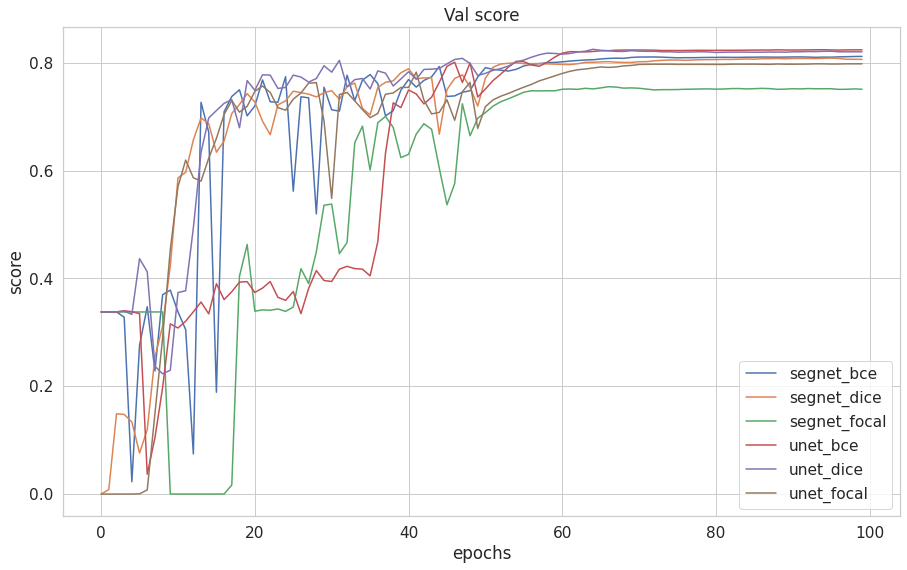

In [146]:
history_dict = {'segnet_bce': history_segnet_bce,
                'segnet_dice': history_segnet_dice,
                'segnet_focal': history_segnet_focal,
                'unet_bce': history_unet_bce,
                'unet_dice': history_unet_dice,
                'unet_focal': history_unet_focal}

plt.figure(figsize=(15, 9))
plt.title('Val score')

for name, history in history_dict.items():
    train_loss, val_loss, train_score, val_score = zip(*history)
    
    plt.plot(val_score, label=f"{name}")

plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("score")

plt.show()

Сравним модели, показавшие лучший результат. Скорость обучения примерно у всех моделей одинаковая - в районе 60 эпох. У моделей с dice_loss графики лосс и скора более гладкие.

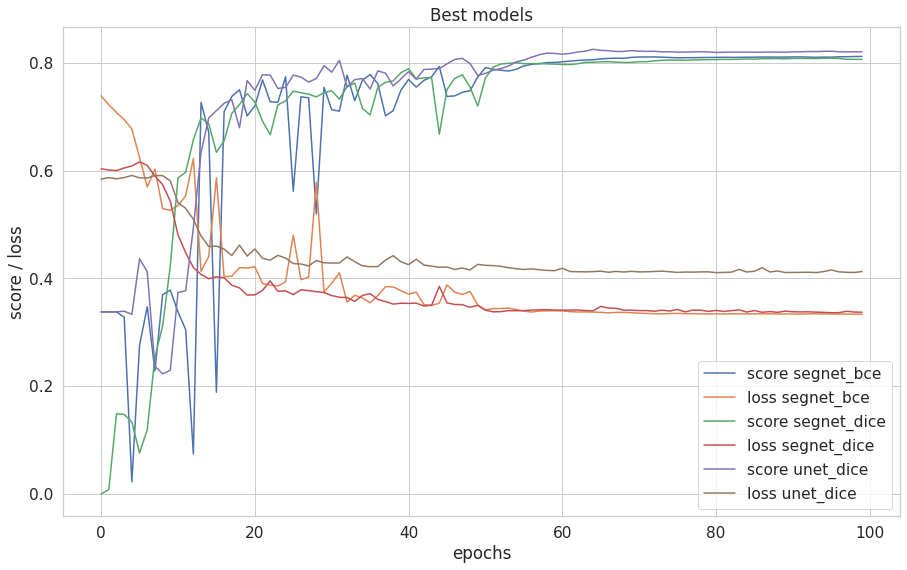

In [147]:
history_dict = {'segnet_bce': history_segnet_bce,
                'segnet_dice': history_segnet_dice,
                'unet_dice': history_unet_dice}

plt.figure(figsize=(15, 9))
plt.title('Best models')

for name, history in history_dict.items():
    train_loss, val_loss, train_score, val_score = zip(*history)
    
    plt.plot(val_score, label=f"score {name}")
    plt.plot(val_loss, label=f"loss {name}")

plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("score / loss")

plt.show()

Модели SegNet с разными метриками. Focal_loss дало наихудший результат

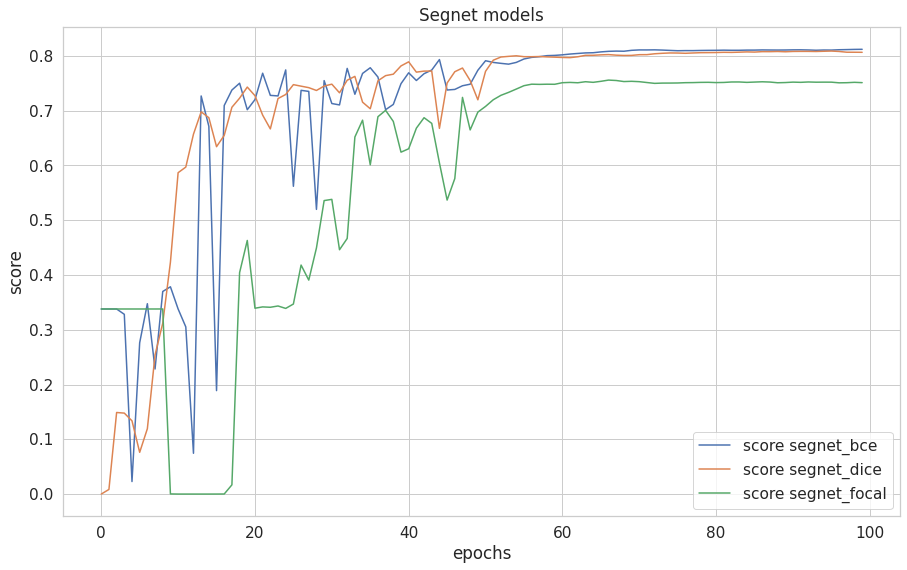

In [148]:
history_dict = {'segnet_bce': history_segnet_bce,
                'segnet_dice': history_segnet_dice,
                'segnet_focal': history_segnet_focal}

plt.figure(figsize=(15, 9))
plt.title('Segnet models')

for name, history in history_dict.items():
    train_loss, val_loss, train_score, val_score = zip(*history)
    
    plt.plot(val_score, label=f"score {name}")

plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("score")

plt.show()

Модели UNet. Также focal_loss хуже всех

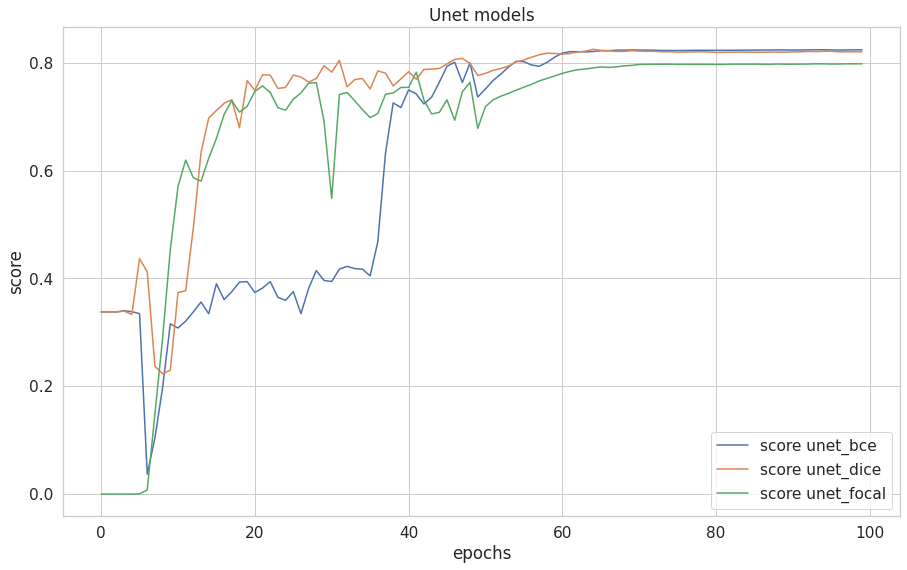

In [149]:
history_dict = {'unet_bce': history_unet_bce,
                'unet_dice': history_unet_dice,
                'unet_focal': history_unet_focal}

plt.figure(figsize=(15, 9))
plt.title('Unet models')

for name, history in history_dict.items():
    train_loss, val_loss, train_score, val_score = zip(*history)
    
    plt.plot(val_score, label=f"score {name}")

plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("score")

plt.show()

DICE. Unet и SegNet

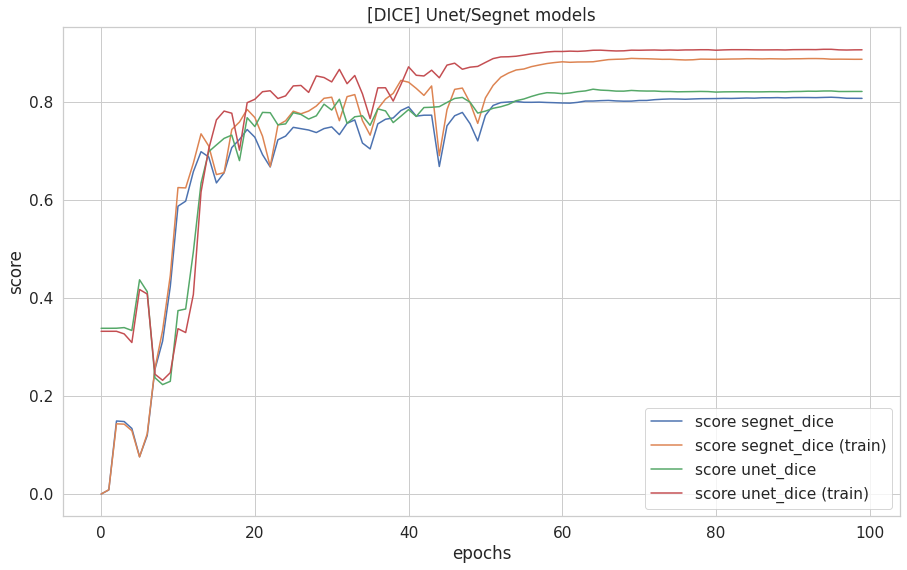

In [153]:
history_dict = {'segnet_dice': history_segnet_dice,                
                'unet_dice': history_unet_dice}

plt.figure(figsize=(15, 9))
plt.title('[DICE] Unet/Segnet models')

for name, history in history_dict.items():
    train_loss, val_loss, train_score, val_score = zip(*history)
    
    plt.plot(val_score, label=f"score {name}")
    plt.plot(train_score, label=f"score {name} (train)")

plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("score")

plt.show()

BCE. Unet и SegNet

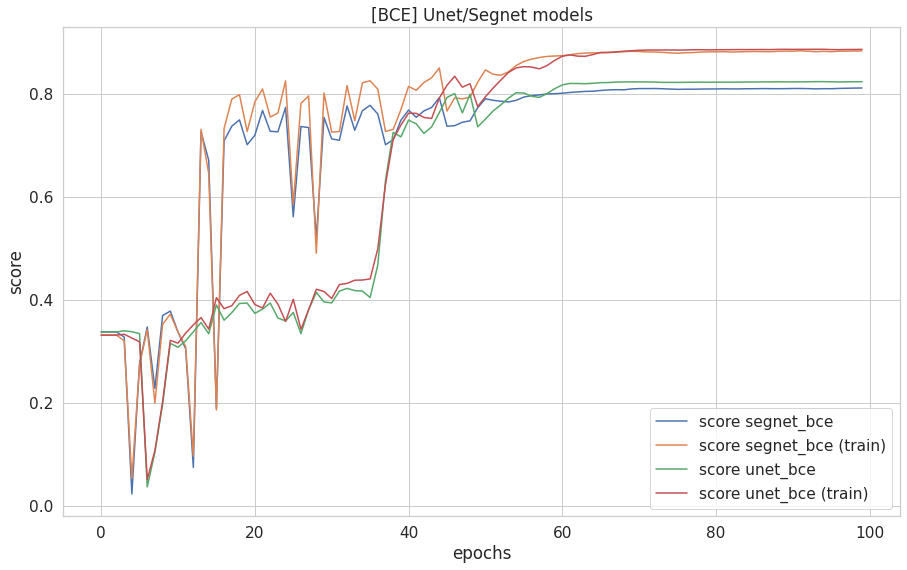

In [154]:
history_dict = {'segnet_bce': history_segnet_bce,                
                'unet_bce': history_unet_bce}

plt.figure(figsize=(15, 9))
plt.title('[BCE] Unet/Segnet models')

for name, history in history_dict.items():
    train_loss, val_loss, train_score, val_score = zip(*history)
    
    plt.plot(val_score, label=f"score {name}")
    plt.plot(train_score, label=f"score {name} (train)")

plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("score")

plt.show()

FOCAL. Unet и SegNet

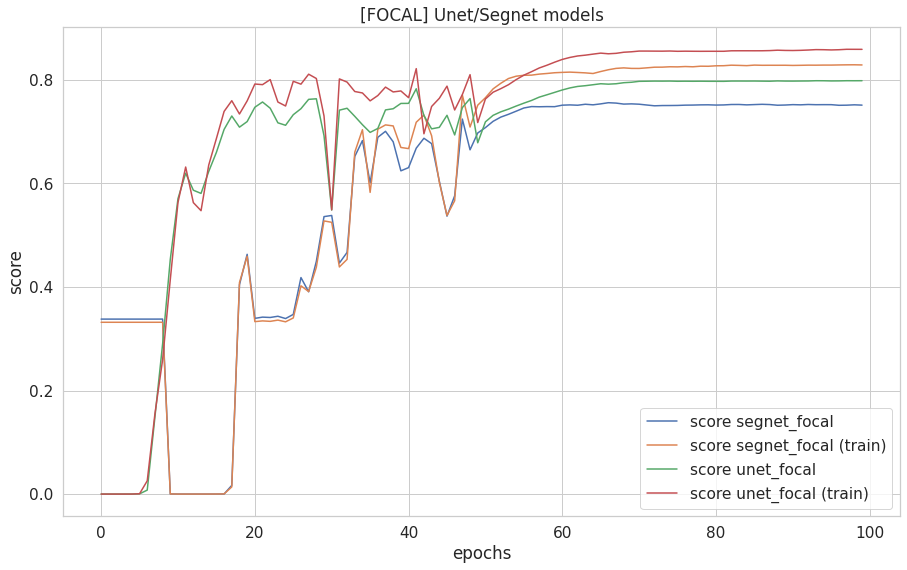

In [156]:
history_dict = {'segnet_focal': history_segnet_focal,                
                'unet_focal': history_unet_focal}

plt.figure(figsize=(15, 9))
plt.title('[FOCAL] Unet/Segnet models')

for name, history in history_dict.items():
    train_loss, val_loss, train_score, val_score = zip(*history)
    
    plt.plot(val_score, label=f"score {name}")
    plt.plot(train_score, label=f"score {name} (train)")

plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("score")

plt.show()